# Universe Machine

# Notes


TODO:
* Once things are restructured get this ready for PR
* https://docs.google.com/document/d/1kRZUw_nHksmnfgu_u6OtERTrl_w-xgio5t7WndmFQPA/edit
* https://redwoodforest.slack.com/archives/D6UA26L6R/p1515102490000636
* Decide how to drop data in the heatmaps
* Sanity check that halo scatter matches stellar scatter (based off the slope): https://redwoodforest.slack.com/archives/C8G02V8F9/p1516236118000202

New TODO:

# Preamble, Imports, Plotting config

In [308]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
np.set_printoptions(linewidth=1000)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [314]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import astropy.io.fits
import time
import pandas as pd
import scipy

# My libs
import data
import plots as p
import smhm_fit
import fits
import halo_info
import origin_scatter


# when we mess up imports
from importlib import reload

In [315]:
mpl.rcParams.update({'figure.dpi': 200})
def fig_font_size(size = 12):
    mpl.rcParams.update({'font.size': size})
fig_font_size()

# Data

In [ ]:
# Note that we have already cut (as of 1 Feb) to centrals with mp > 12
# https://github.com/dr-guangtou/hsc_um2/blob/master/scripts/reduce_um_data_size.py
centrals, satellites = data.load()
print(np.log10(np.min(centrals["mp"])))
print(len(centrals))

### Vis raw data

In [ ]:
d = data_stellar_cut["cen"]["data"]
hm_phm_ratio = d["m"] / d["mp"]

fig, ax = plt.subplots()
ax.hist(hm_phm_ratio, bins=50)
ax.set(
    yscale="log",
    ylabel="Count",
    xlabel="HM / Peak HM",
)

In [ ]:
d.dtype

In [ ]:
d  = data_stellar_cut["cen"]["data"], data_stellar_cut["halo"]["data"]
dh = data_stellar_cut["halo"]["data"]["id" == d["id"]]
sm_hm_ratio = (d["sm"] + d["icl"]) / d["m"]
cen_sm_perc = (d["sm"] + d["icl"]) / (dh["sm"] + dh["icl"])

plt.histogram(sm_hm_ratio, cen_sm_perc, bins=50)

In [ ]:
d = data_stellar_cut["cen"]["data"]
sm_hm_ratio = (d["sm"] + d["icl"]) / d["m"]
fig, ax = plt.subplots()
ax.hist(sm_hm_ratio, bins=50)
ax.set(
    ylabel="Count",
    xlabel="SM / HM",
)
ax.axvline(0.2, color="r")

In [ ]:
hm = np.log10(centrals["m"])
sm = np.log10(centrals["sm"] + centrals["icl"])
hist, x_edge, y_edge = np.histogram2d(hm, sm, bins=50)

hist = np.log10(hist)
hist = hist.T

fig, ax = plt.subplots()
img = ax.imshow(hist, origin="lower", extent=[x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]], aspect="auto")
fig.colorbar(img)
ax.set(
    xlabel="HM",
    ylabel="SM",
)
ax.axhline(11.2)
ax.axvline(13)
#ax.axhline(12, c="r")
#ax.axvline(14.5, c="r")

In [ ]:
csm = np.log10(data_halo_cut["cen"]["data"]["sm"] + data_halo_cut["cen"]["data"]["icl"])
hsm = np.log10(data_halo_cut["halo"]["data"]["sm"] + data_halo_cut["halo"]["data"]["icl"])
hist, x_edge, y_edge = np.histogram2d(hsm, csm, bins=50)

hist = np.log10(hist)
hist = hist.T

fig, ax = plt.subplots()
img = ax.imshow(hist, origin="lower", extent=[x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]], aspect="auto")
fig.colorbar(img)
ax.set(
    xlabel="HSM",
    ylabel="CSM",
)
ax.axhline(11.2)
ax.axvline(13)
#ax.axhline(12, c="r")
#ax.axvline(14.5, c="r")

## Process data

### Data with N sats

In [ ]:
data_stellar_cut, data_halo_cut = data.cuts_with_sats(centrals, satellites)

In [ ]:
for key in data_stellar_cut.keys():
    mass, csmf = fits.build_csmf(data_stellar_cut, key)
    data_stellar_cut[key]["smf"] = (mass, csmf) # note that these masses are log!

for key in data_halo_cut.keys():
    mass, csmf = fits.build_csmf(data_halo_cut, key)
    data_halo_cut[key]["smf"] = (mass, csmf) # note that these masses are log!
data_stellar_cut
data_stellar_cut["cen"]["hmf"] = fits.build_chmf(data_stellar_cut, "cen")

In [ ]:
for ds in [data_stellar_cut, data_halo_cut]:
    for key in ds.keys():
        for key2 in ds[key].keys():
            if type(ds[key][key2]) is np.ndarray:
                ds[key][key2].setflags(write=False)
            elif type(ds[key][key2]) is tuple:
                for i in range(len(ds[key][key2])):
                    ds[key][key2][i].setflags(write=False)

### Richness data

In [542]:
richness = {
    "richness": data.create_richness_data(centrals, satellites),
}

In [543]:
richness["rmf"] = fits.build_rmf(richness["richness"])
richness["photoz_rmf"] = fits.build_rmf(richness["richness"])

### Sanity checks/exploration

In [ ]:
r = richness["richness"]["richness"]
r1 = richness["richness"]["photoz_richness"]

x = plt.hist(r, bins=np.arange(75), alpha=0.5)
x = plt.hist(r1, bins=np.arange(75), alpha=0.5)

plt.yscale('log', nonposy='clip')

print(np.count_nonzero(r >= 1))
print(np.sum(r))
print(np.count_nonzero(r1 >= 1))

In [ ]:
# https://arxiv.org/pdf/1410.1193.pdf says that 6.2% of richness comes from non cluster galaxies
# With an error of 52 we get 24%
print(np.sum(r))
print(np.sum(r1))
print(np.average(r1[r >= 20]/r[r >= 20]))

In [ ]:
print(data_stellar_cut.keys())
for key in data_stellar_cut.keys():
    print(key)
    print(key, len(data_stellar_cut[key]["data"]), len(data_halo_cut[key]["data"]))

In [ ]:
print(data_halo_cut.keys())
print(data_halo_cut["cen"].keys())
print(data_stellar_cut["cen"].keys())
print(len(data_stellar_cut["cen"]["data_cut"]))

### Sanity check these fits

They all kinda look like power laws? A little too much like power laws.

Also some analysis of these fits in the paper

If we are going for a power law, we have
```
log(HM) = log(M1) + B log(SM / sm0)
HM = M1 * (SM/sm0)^B = M1 * SM^B / (sm0)^B = M1/sm0^B * SM^B
log(HM) = log(M1/sm0*B) + B*log(SM)
log(HM) = log(M1)-log(sm0) - log(B) + B*SM
```

In [ ]:
print("m1, sm0, beta, delta, gamma")
for key in data_halo_cut.keys():
    f = data_halo_cut[key]["fit"]
    print("{}, {:2f}, {:2f}, {:2f}, {:2f}, {:2f}".format(key, np.log10(f[0]), np.log10(f[1]), f[2], f[3], f[4]))

In [ ]:
def get_power_law_coeffs(m1, sm0, beta, delta, gamma):
    if np.abs(gamma) > 1e-9 or np.abs(delta) > 1e-9:
        print("not a power law!")
        return
    # y = az^(b)
    a = np.log10(m1) - np.log10(sm0) - np.log10(beta)
    b = beta
    print("HM = {} * SM ^ {}".format(a, b))
    print("SM = {} * HM ^ {}".format(1/(a**(1/b)), 1/b))
for key in data_halo_cut.keys():
    print(key)
    get_power_law_coeffs(*data_halo_cut[key]["fit"])
for key in data_stellar_cut.keys():
    print(key)
    get_power_law_coeffs(*data_stellar_cut[key]["fit"])

In [ ]:
for key in data_halo_cut.keys():
    print(data_halo_cut[key]["fit"])

#### Plots

In [ ]:
_, ax = plt.subplots()
for key in ["cen", 1, "halo"]: #data_stellar_cut.keys():
    p.sm_hm.hm_at_fixed_sm(data_stellar_cut[key]["data"], key, fit=data_stellar_cut[key]["fit"], ax =ax)

In [ ]:
for key in ["cen"]:#data_halo_cut.keys():
    p.sm_hm.sm_at_fixed_hm(data_halo_cut[key]["data"], key, fit=data_halo_cut[key]["fit"])

# Intro Plot

Intro everything by showing the SM-HM plot + some of the scatter plots (including lit values)

[14726, 9279, 5597, 3294, 1822, 974, 469, 203, 92, 27, 6]
[0.40262902 0.41020818 0.40768802 0.40410948 0.38890459 0.37148644 0.40066782 0.3828029  0.44368893 0.25534042 0.17569816]
[14726, 9279, 5597, 3294, 1822, 974, 469, 204, 92, 27, 6]
[0.28774009 0.2727325  0.25552805 0.23936585 0.22270942 0.21262455 0.2137834  0.22145148 0.17039301 0.20107987 0.17112008]
[14726, 9279, 5597, 3294, 1822, 974, 469, 204, 92, 27, 6]
[0.18661211 0.15889604 0.13249561 0.11266014 0.0928372  0.07683491 0.07063572 0.05560238 0.04494148 0.04521744 0.02338945]


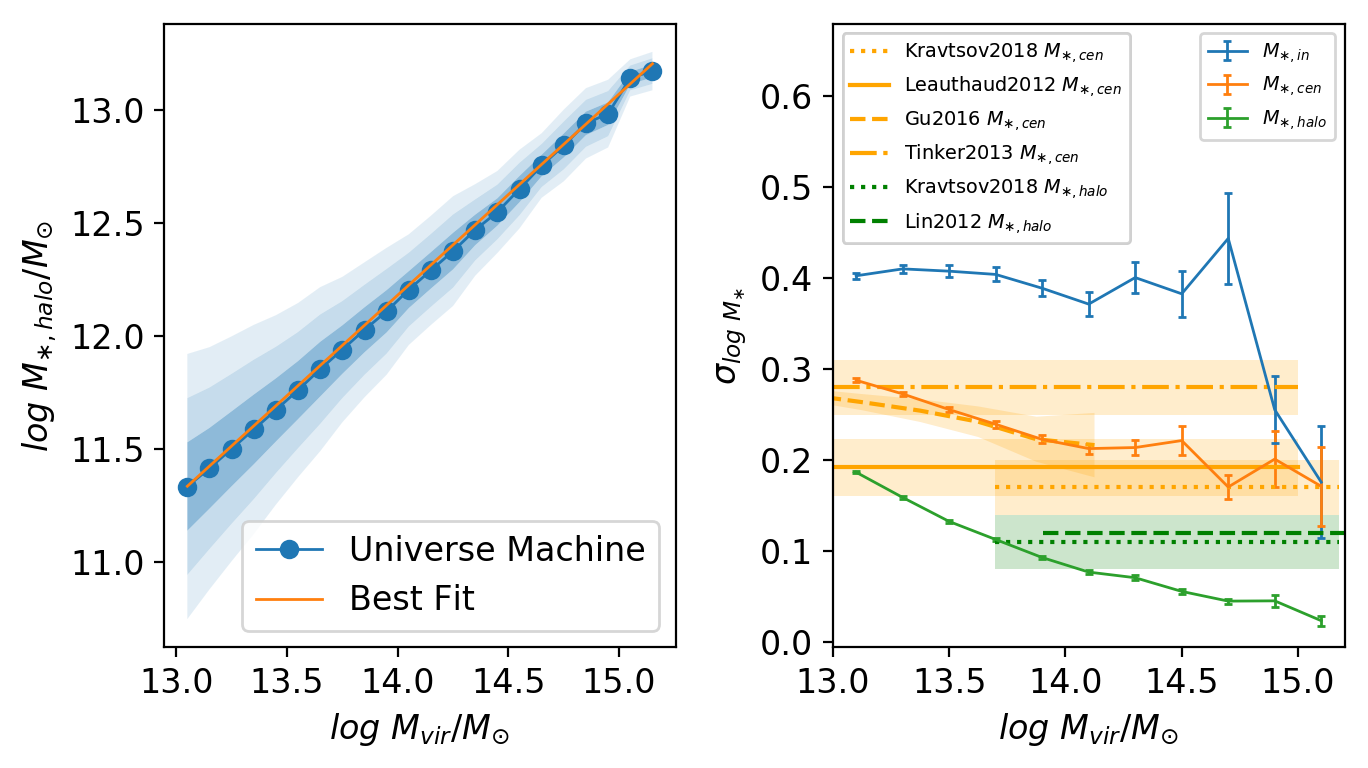

In [575]:
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(7, 4)
p.sm_hm.sm_at_fixed_hm(data_halo_cut["halo"]["data"], "halo", fit=data_halo_cut["halo"]["fit"], ax=axes[0])
p.scatter.in_sm_at_fixed_hm_incl_lit(data_halo_cut, ax=axes[1])
plt.tight_layout()

# Scatter for various definitions of stellar mass

[14726, 9279, 5597, 3294, 1822, 974, 469, 204, 92, 27, 6]
[14726, 9279, 5597, 3294, 1822, 974, 469, 204, 92, 27, 6]
[14726, 9279, 5597, 3294, 1822, 974, 469, 204, 92, 27, 6]
[14726, 9279, 5597, 3294, 1822, 974, 469, 204, 92, 27, 6]
[14726, 9279, 5597, 3294, 1822, 974, 469, 204, 92, 27, 6]
[12.48253297 12.36329538 12.28477307 12.17716842 12.0550226  11.91833561 11.77583216 11.6333287  11.48500878 11.32796415]
[11, 27, 62, 149, 353, 839, 1996, 4847, 11381]
[12.55864091 12.46654536 12.38840367 12.29072657 12.16514172 12.03955688 11.91397203 11.76885177 11.61535918 11.44791271]
[10, 27, 62, 150, 359, 833, 2048, 4806, 11415]
[12.59418527 12.5127637  12.44762645 12.35263463 12.23050229 12.10836994 11.98080949 11.83696473 11.67954971 11.49499417]
[12, 27, 60, 147, 350, 862, 2023, 4768, 11597]
[12.692745   12.6125063  12.54712663 12.44311351 12.33612858 12.21131284 12.08352529 11.93196332 11.75365511 11.54265706]
[10, 27, 62, 150, 354, 831, 2053, 4811, 11479]
[13.06926974 12.97500532 12.872885

(0.0, 0.4572629893573631)

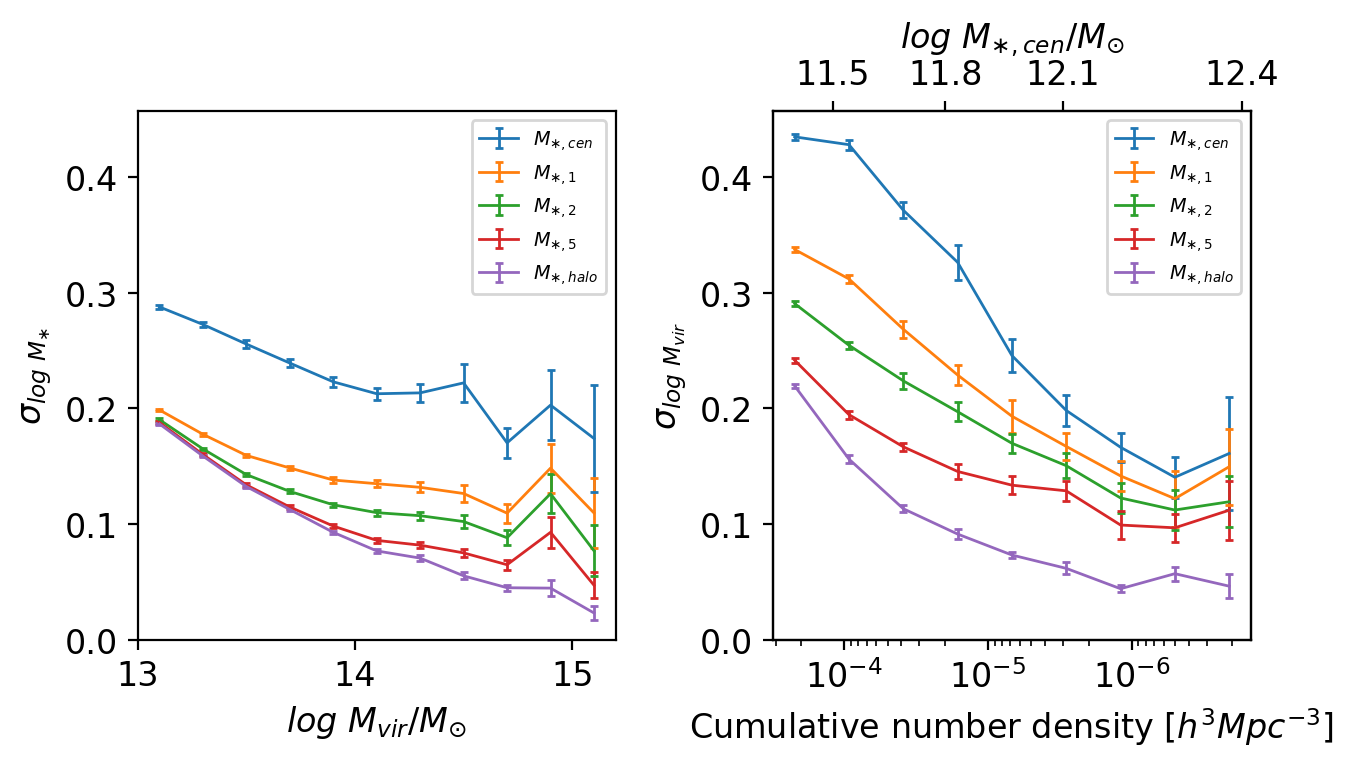

In [576]:
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(7, 4)
p.scatter.in_sm_at_fixed_hm(data_halo_cut, ax=axes[0])
p.scatter.in_hm_at_fixed_number_density(data_stellar_cut, ax=axes[1])
plt.tight_layout()
axes[0].set_ylim(axes[1].get_ylim())

# Stellar mass function for various SMs and vs HSC etc


In [ ]:
assert fits.density_at_mass(data_stellar_cut, "cen", fits.mass_at_density(data_stellar_cut, "cen", 1e2)) == 1e2

In [ ]:
_, ax = plt.subplots()
for key in data_stellar_cut.keys():
    smf_data = data_stellar_cut[key]["smf"]
    ax.plot(smf_data[0], smf_data[1], label=key)
ax.set_yscale("log")
ax.legend()

In [ ]:
_, ax = plt.subplots()
for key in data_stellar_cut.keys():
    smf_data = data_stellar_cut[key]["smf"]
    ax.plot(smf_data[0], smf_data[1], label=key)
ax.set_yscale("log")
ax.legend()

### Comparison with HSC etc

In [ ]:
hsc_smf_file_m10 = "/home/christopher/research/hsc_um2/data/s16a_massive_fastlane_logm10_smf_default.fits"
hsc_smf_file_m100 = "/home/christopher/research/hsc_um2/data/s16a_massive_fastlane_logm100_smf_default.fits"

m10_smf = astropy.io.fits.open(hsc_smf_file_m10)[1].data
m100_smf = astropy.io.fits.open(hsc_smf_file_m100)[1].data

In [ ]:
print(m10_smf.dtype)
print(m10_smf)

In [ ]:
def plot_sim_smf(stellar_masses, ax, label):

    nonzero_stellar_masses = np.log10(stellar_masses[stellar_masses != 0])
    print("Dropped {} galaxies with mass of 0".format(len(stellar_masses) - len(nonzero_stellar_masses)))

    sim_volume = 400**3 # https://redwoodforest.slack.com/archives/C5W6EQCAU/p1513187949000425 SMDPL
    num_bins = 30
    x, y, err = smf.compute_smf(
        nonzero_stellar_masses, sim_volume, num_bins, 
        np.min(nonzero_stellar_masses), np.max(nonzero_stellar_masses),
    )
    ax.errorbar(x, y, yerr = err, label=label)


fig, ax = plt.subplots()
ax.errorbar(m10_smf["logm_mean"], m10_smf["smf"], yerr = m10_smf["smf_err"], label="HSC m10")
ax.errorbar(m100_smf["logm_mean"], m100_smf["smf"], yerr = m100_smf["smf_err"], label="HSC m100")
plot_sim_smf(centrals["sm"], ax, "universe machine insitu centrals")
plot_sim_smf(centrals["sm"] + centrals["icl"], ax, "all mass cents")
plot_sim_smf(np.append(centrals["sm"] + centrals["icl"], satellites["sm"] + satellites["icl"]), ax, "all mass cents and sats")
ax.legend()
ax.set(
    yscale="log",
    xlim=[11, 12.4],
)
fig.set_size_inches(18.5, 10.5)

# Richness as an estimator

What about richness? Does that have a relation with scatter at fixed halo mass

## Sanity check RMF

In [ ]:
fits.density_at_richness(data_stellar_cut, "cen", fits.richness_at_density(data_stellar_cut, "cen", 2e-4))

In [ ]:
#p.scatter.in_richness_at_fixed_hm(data_halo_cut)
#p.scatter.in_hm_at_fixed_richness_number_density(data_stellar_cut)

_, ax = plt.subplots()
rmf_data = data_stellar_cut["cen"]["rmf"]
ax.plot(rmf_data[0], rmf_data[1], label="stellar cut")
rmf_data = data_halo_cut["cen"]["rmf"]
ax.plot(rmf_data[0], rmf_data[1], label="halo cut")
ax.set_yscale("log")
ax.legend()

In [ ]:
r = data_stellar_cut["cen"]["richness"]

ex = r[r["richness"] == 2]
#plt.hist(r, bins=int(np.max(r["richness"])))
#plt.yscale("log")
plt.hist(np.log10(ex["m"]))

## Richness plots


In [ ]:
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(7, 4)
fig.subplots_adjust(wspace=0.28)
p.scatter.in_hm_at_fixed_richness_number_density(richness, axes[0])
p.scatter.in_hm_at_fixed_number_density_incl_richness(data_stellar_cut, richness, axes[1])


### Old color plots

In [ ]:
# Only count sats of a large enough size towards richness
minMassForRichness = 10**10.8
richness = cluster_sum.get_richness(centrals_halo_cut, satellites, minMassForRichness)
print("Out of {} clusters, {} have a richness > 0".format(len(richness), np.count_nonzero(richness)))
heatmaps.richness_and_hm_vs_sm_scatter(
    data_halo_cut[0]["data"],
    satellites,
    minMassForRichness,
    data_halo_cut[0]["fit"],
    0,
)

In [ ]:
heatmaps.richness_and_sm_vs_hm_scatter(
    data_stellar_cut[0]["data"],
    satellites,
    minMassForRichness,
    data_stellar_cut[0]["fit"],
    0,
)

# Is cen\* | halo\* scatter correlated with halo\* | vir scatter?

We are asking here whether we can show: s stands to sigma - scatter

s(cen | vir) = s(cen | halo) + s(halo | vir)

1) Are these two scatter correlated (does saying something about the bias in s(cen | halo) say anything about the scatter in s(halo | vir)

In [ ]:
cens_bias = halo_info.get_sm_bias(data_halo_cut["cen"], include_id=True)
cens_bias = pd.DataFrame(cens_bias).set_index("id")
cens_bias = cens_bias.rename(columns={"sm_bias": "cen_sm_bias"})

halo_bias = halo_info.get_sm_bias(data_halo_cut["halo"], include_id=True)
halo_bias = pd.DataFrame(halo_bias).set_index("id")
halo_bias = halo_bias.rename(columns={"sm_bias": "halo_sm_bias"})

In [387]:
z = data.unify(data_halo_cut, "cen", "halo", append=[halo_bias, cens_bias])

In [389]:
res = halo_info.build_sm_sm_bias_fit(z)

[5.19852376e+11 2.23073740e+11 9.13423074e-01 9.22352592e-03 1.13704117e+00]


In [390]:
z = z.assign(cen_halo_sm_bias = halo_info.get_sm_sm_bias(z, res["fit"]))

In [424]:
z["gammas1"] = p.same_hm_dist_plots.f_acc(z, n_dyn=1) # This takes Acc_Rate_1*Tdyn and returns the unitless gamma
z["gammas2"] = p.same_hm_dist_plots.f_acc(z, n_dyn=2)
z["gammas3"] = p.same_hm_dist_plots.f_acc(z, n_dyn="100Myr")

z["concentration"] = z["rvir"] / z["rs"]

468 here are less than 0
7274 here are less than 0


/home/christopher/research/hsc_um2/cb/plots/same_hm_dist_plots.py:188: RuntimeWarning: invalid value encountered in log10
  np.log10(sample["m"]) - np.log10(sample["m"] - delta_mass)) / (


In [548]:
before_len = len(z)
z = z.join(pd.DataFrame(richness["richness"][["id", "richness"]]).set_index("id"), how="inner")
assert len(z) == before_len

In [549]:
print(len(z))
for bias in ["cen_halo_sm_bias", "halo_sm_bias", "cen_sm_bias"]:
    print(np.mean(z[bias]))
z.head()

1076948
0.00013518044545439203
-0.062496541533895285
0.0007683297849828373


,id,upid,x,y,z,m,mp,sm_cen,icl_cen,sfr_cen,...,icl_halo,sfr_halo,halo_sm_bias,cen_sm_bias,cen_halo_sm_bias,gammas1,gammas2,gammas3,concentration,richness
8272346909,8272346909,-1,14.669590,16.224859,17.419121,3.406000e+11,3.406000e+11,5.327000e+09,1.717000e+08,2.29100,...,1.787160e+08,2.405000,-0.207289,0.105879,-0.018198,0.259855,0.189337,0.482833,11.169264,0
8272346933,8272346933,-1,12.411820,18.139450,16.151751,3.823000e+11,7.532000e+11,2.910000e+10,1.008000e+09,3.47700,...,1.008000e+09,3.477000,0.448433,0.742831,0.030272,-0.384624,-0.863238,0.245121,20.318802,0
8272346989,8272346989,-1,15.005470,17.348749,17.362949,4.391000e+11,4.425000e+11,2.205000e+10,6.076000e+08,3.05400,...,6.076000e+08,3.054001,0.271477,0.498158,0.019600,0.385209,-0.011518,0.083319,11.646040,0
8272347167,8272347167,-1,16.087311,16.738159,15.850960,4.749000e+11,5.261000e+11,1.871000e+10,7.123000e+08,2.49000,...,7.498400e+08,2.687620,0.189399,0.363125,0.001390,-0.394697,0.037182,-0.334679,8.417439,0
8272347463,8272347463,-1,13.668280,17.073250,15.775540,1.226000e+12,2.214000e+12,4.383000e+10,2.421000e+10,0.06079,...,2.421000e+10,0.060790,0.352550,0.272503,0.088189,-1.624898,-0.961369,-0.343486,15.207379,1


In [553]:
cutz = z[z["m"] > 10**14]
print(len(cutz))
for bias in ["cen_halo_sm_bias", "halo_sm_bias", "cen_sm_bias"]:
    print(np.mean(cutz[bias]))
cutz.head()

1772
0.00596100457711093
-0.019652934588186864
-0.017810710840969295


,id,upid,x,y,z,m,mp,sm_cen,icl_cen,sfr_cen,...,icl_halo,sfr_halo,halo_sm_bias,cen_sm_bias,cen_halo_sm_bias,gammas1,gammas2,gammas3,concentration,richness
8272347969,8272347969,-1,14.210560,17.447241,16.636551,1.509000e+14,1.509000e+14,6.128000e+10,3.866000e+11,0.18180,...,7.056346e+11,50.940251,0.097265,-0.116217,-0.173780,1.224407,0.786313,2.770003,3.537423,13
8272349832,8272349832,-1,9.257070,17.288000,15.062750,1.136000e+14,1.136000e+14,1.342000e+11,1.567000e+11,0.29100,...,5.156953e+11,25.666902,-0.133913,-0.211729,-0.127677,2.237536,4.607980,1.013760,3.454240,9
8272569901,8272569901,-1,3.672640,19.232460,244.792038,1.631000e+14,1.631000e+14,4.012000e+10,5.708000e+11,0.08378,...,8.085146e+11,58.389740,-0.115313,-0.006287,0.088809,0.876740,1.128865,0.818229,4.488790,9
8272598514,8272598514,-1,6.834960,13.066310,250.439590,1.201000e+14,1.325000e+14,4.211000e+10,3.340000e+11,0.02252,...,4.656904e+11,57.025967,-0.036753,-0.118271,-0.095011,-0.135419,0.632125,1.295053,5.825940,8
8272642416,8272642416,-1,19.784161,14.608490,264.776398,1.932000e+14,1.932000e+14,7.735000e+10,6.351000e+11,0.04078,...,7.779202e+11,108.571786,-0.056371,0.006751,0.069342,2.402252,1.504285,1.290387,7.082326,9


In [393]:
#print(np.cov(z["cen_halo_sm_bias"], z["halo_sm_bias"]))
print(np.cov(cutz["cen_halo_sm_bias"], cutz["halo_sm_bias"]))
print(np.corrcoef(cutz["cen_halo_sm_bias"], cutz["halo_sm_bias"]))

[[ 0.043471   -0.00049645]
 [-0.00049645  0.00506778]]
[[ 1.         -0.03344807]
 [-0.03344807  1.        ]]


In [394]:
testz = z[(z["m"] > 10**13.45) & (z["m"] < 10**13.55)]
print(len(testz))
print(np.mean(testz["sm_cen"]  / (testz["icl_cen"] +testz["sm_halo"] + testz["icl_halo"])))
testz.head()

2800
0.13728480154799425


,id,upid,x,y,z,m,mp,sm_cen,icl_cen,sfr_cen,...,Acc_Rate_1*Tdyn,Acc_Rate_2*Tdyn,Acc_Rate_Mpeak,Vmax@Mpeak,sm_halo,icl_halo,sfr_halo,halo_sm_bias,cen_sm_bias,cen_halo_sm_bias
8272351961,8272351961,-1,3.798120,8.814490,1.535360,2.939000e+13,2.939000e+13,1.226000e+11,2.695000e+11,0.33380,...,603.2,1416.0,3043.0,484.55,3.120555e+11,2.796805e+11,15.284733,0.065202,0.337817,0.209317
8272352295,8272352295,-1,7.245790,14.820780,11.034040,2.872000e+13,2.872000e+13,5.596000e+10,1.472000e+11,0.07084,...,1283.0,1404.0,1341.0,500.47,1.983660e+11,1.527972e+11,15.398755,-0.152512,0.058407,0.067719
8272375404,8272375404,-1,11.980260,16.908739,39.661461,3.358000e+13,3.358000e+13,1.246000e+11,3.256000e+10,0.23580,...,3223.0,4020.0,3619.0,512.16,2.594203e+11,4.054799e+10,14.271574,-0.281313,-0.095758,0.000199
8272522311,8272522311,-1,28.105539,22.172310,181.676636,2.903000e+13,2.903000e+13,1.579000e+11,2.535000e+11,0.56470,...,1987.0,2293.0,2133.0,467.16,3.406550e+11,2.636954e+11,14.979810,0.079122,0.361977,0.224379
8272522751,8272522751,-1,7.836260,14.083910,180.336258,3.190000e+13,3.190000e+13,2.163000e+11,2.089000e+11,0.13930,...,1972.0,3987.0,3956.0,471.43,4.072368e+11,2.318935e+11,33.494311,0.067019,0.350753,0.223301


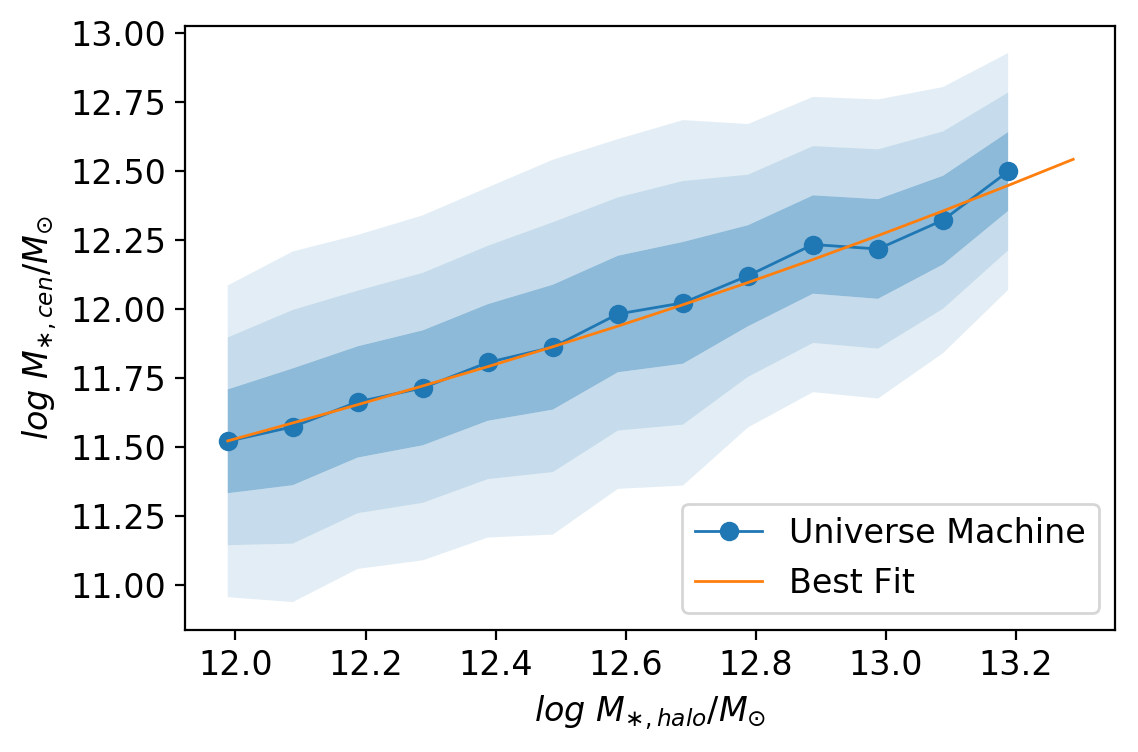

In [395]:
p.sm_hm.sm_cen_at_fixed_sm_halo(cutz, res["fit"])

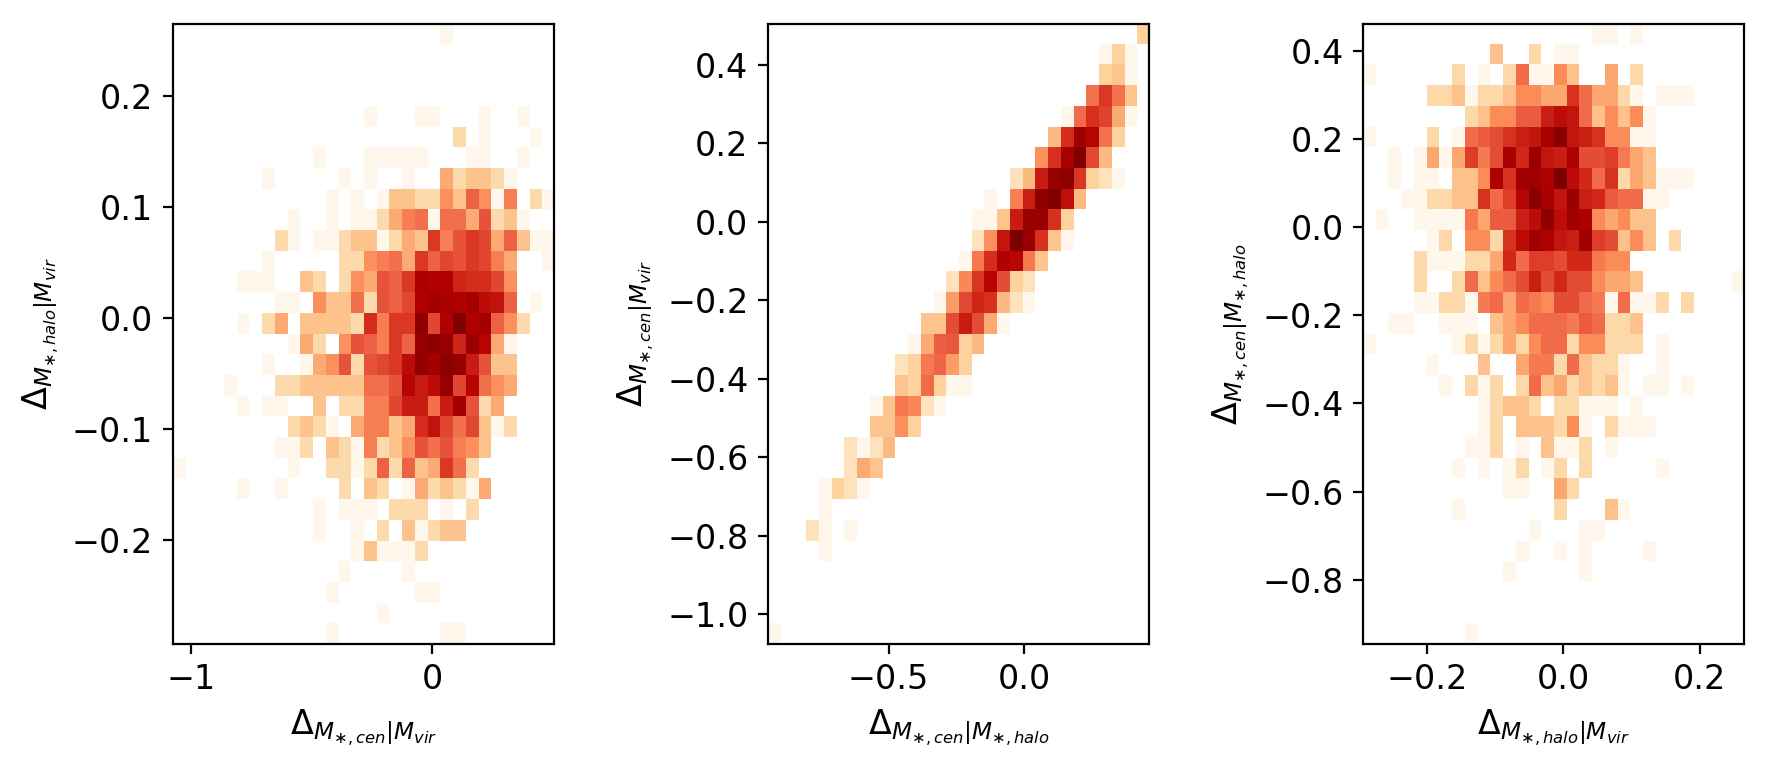

In [396]:
fig, axes = plt.subplots(1, 3)
fig.set_size_inches(9, 4)

#fig, ax = plt.subplots()
ax = axes[0]
_, _, _, img = ax.hist2d(cutz["cen_sm_bias"], cutz["halo_sm_bias"], cmap="OrRd", norm=mpl.colors.LogNorm(), bins=30)
ax.set(xlabel=r"$\Delta_{M_{\ast, cen} | M_{vir}}$", ylabel=r"$\Delta_{M_{\ast, halo} | M_{vir}}$")
#fig.colorbar(img, label="count")

#fig, ax = plt.subplots()
ax = axes[1]
_, _, _, img = ax.hist2d(cutz["cen_halo_sm_bias"], cutz["cen_sm_bias"], cmap="OrRd", norm=mpl.colors.LogNorm(), bins=30)
ax.set(xlabel=r"$\Delta_{M_{\ast, cen} | M_{\ast, halo}}$", ylabel=r"$\Delta_{M_{\ast, cen} | M_{vir}}$")
#plt.colorbar(img, label="count")

#fig, ax = plt.subplots()
ax = axes[2]
_, _, _, img = ax.hist2d(cutz["halo_sm_bias"], cutz["cen_halo_sm_bias"], cmap="OrRd", norm=mpl.colors.LogNorm(), bins=30)
ax.set(xlabel=r"$\Delta_{M_{\ast, halo} | M_{vir}}$", ylabel=r"$\Delta_{M_{\ast, cen} | M_{\ast, halo}}$")
#plt.colorbar(img, label="count")
plt.tight_layout()

# Is cen\* | halo\* fully explained by recent incomplete mergers (No! Lots of noise here)

LinregressResult(slope=-1.550199435094415, intercept=1.0547145051763855, rvalue=-0.3316697953157999, pvalue=0.0, stderr=0.023384998389853272)
SpearmanrResult(correlation=-0.35011129214170217, pvalue=0.0)
LinregressResult(slope=-0.1493209805698243, intercept=0.4604478474398052, rvalue=-0.4268423006991425, pvalue=0.0, stderr=0.001656141552734343)
SpearmanrResult(correlation=-0.444906093849832, pvalue=0.0)
LinregressResult(slope=-0.22430023701205676, intercept=0.3827019108662602, rvalue=-0.3066587873399454, pvalue=0.0, stderr=0.0036445838165081617)
SpearmanrResult(correlation=-0.308592641629507, pvalue=0.0)
LinregressResult(slope=3.2229783479173935, intercept=6.014442620296076, rvalue=0.3685777261003329, pvalue=0.0, stderr=0.0425541581711231)
SpearmanrResult(correlation=0.39600136510939266, pvalue=0.0)
sm_cen 0.5245489023372121
icl_cen 0.5766419605618329


/home/christopher/.virtualenvs/hsc_um2/lib/python3.6/site-packages/numpy/lib/function_base.py:3183: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/christopher/.virtualenvs/hsc_um2/lib/python3.6/site-packages/numpy/lib/function_base.py:3184: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/christopher/.virtualenvs/hsc_um2/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/christopher/.virtualenvs/hsc_um2/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/home/christopher/.virtualenvs/hsc_um2/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


sfr_cen 0.3094624842571505
rs -0.28031271820068276
Halfmass_Scale -0.444906093849832
scale_of_last_MM -0.308592641629507
icl_halo 0.39921320341043776
cen_sm_bias 0.9022683557079629
cen_halo_sm_bias 1.0
gammas2 -0.35011129214170217
concentration 0.39600136510939266
richness -0.2744103780692352


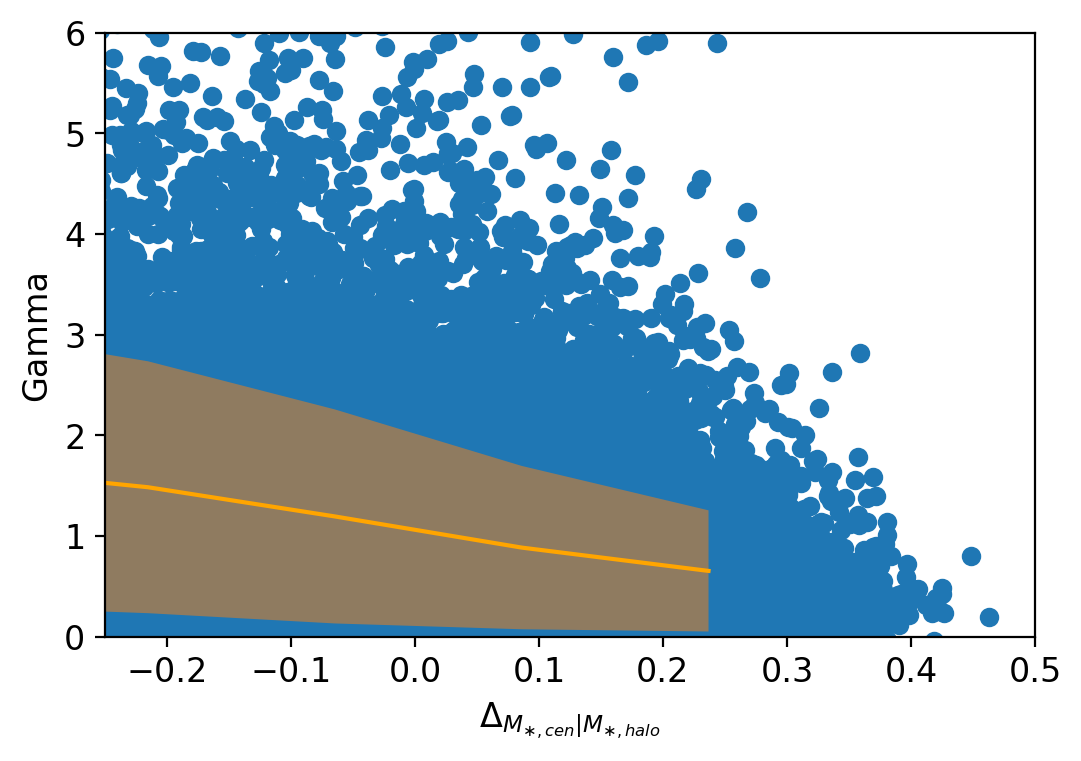

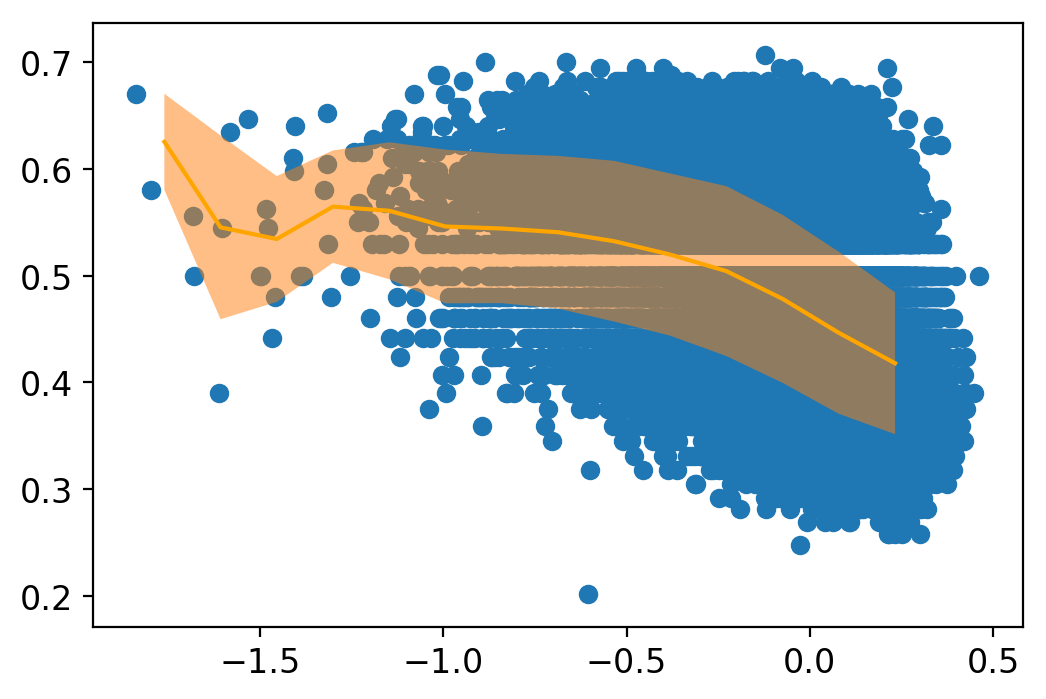

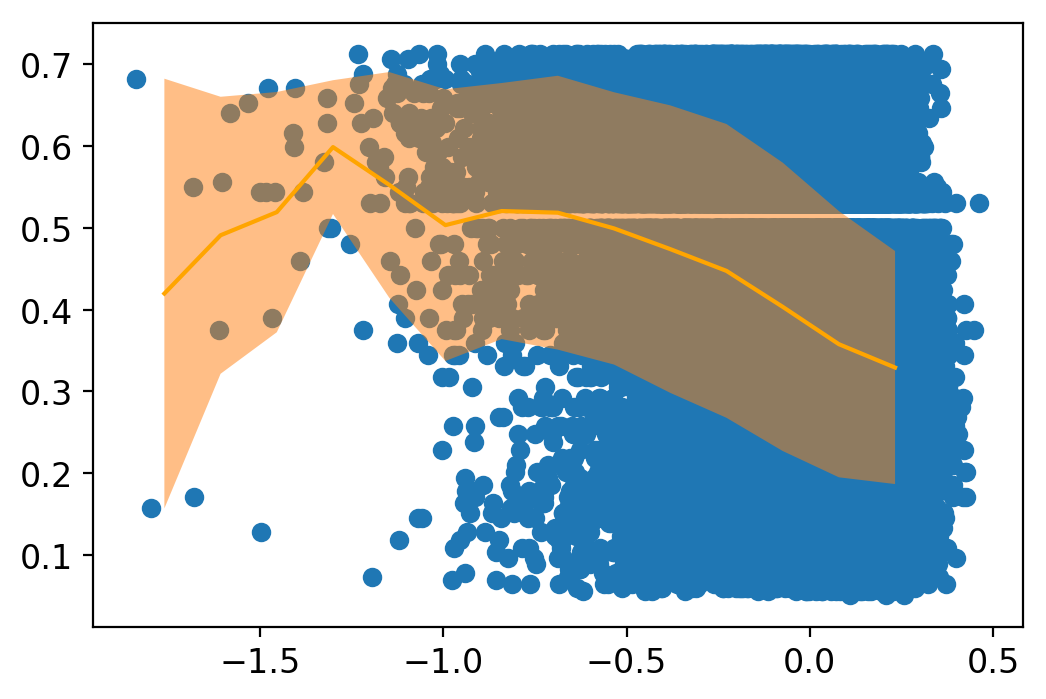

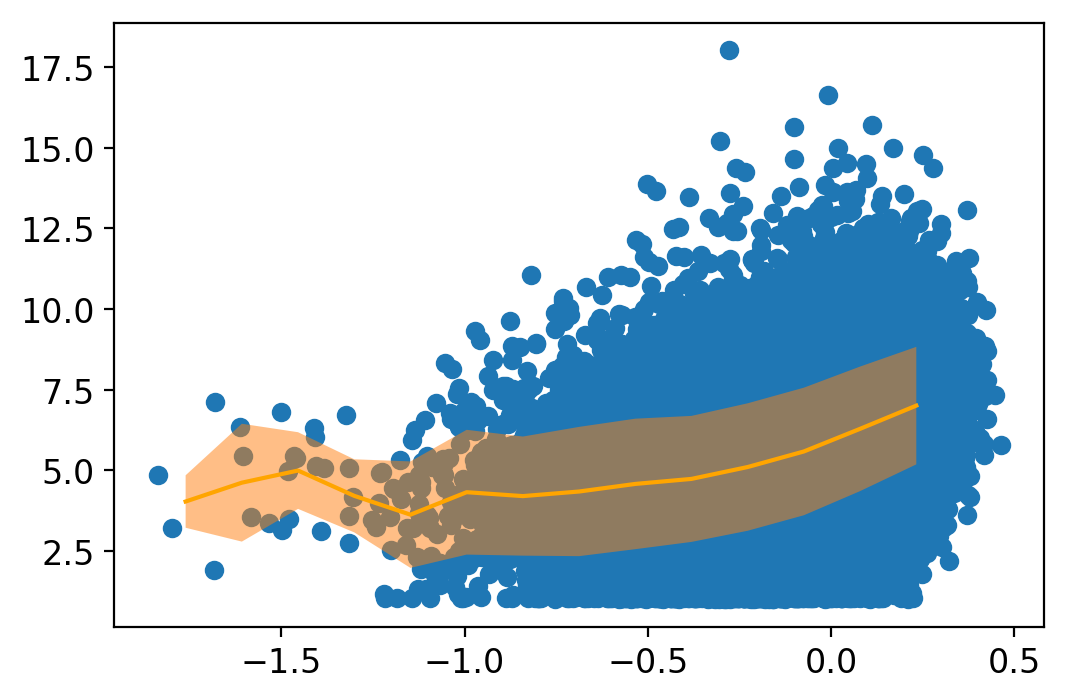

In [555]:
hcutz = z[z["m"] > 10**13]


g_vals = np.logical_not(np.isnan(hcutz["gammas1"])) & np.logical_not(np.isnan(hcutz["gammas2"])) & np.logical_not(np.isnan(hcutz["gammas3"]))

gammas = hcutz["gammas2"][g_vals] #+ gammas2[g_vals]
bias = hcutz["cen_halo_sm_bias"][g_vals]

ax = p.general_scatter.linear(bias, gammas)

#_, ax = plt.subplots()
#ax.scatter(np.log10(gammas), bias)
ax.set(ylabel="Gamma", xlabel=r"$\Delta_{M_{\ast, cen} | M_{\ast, halo}}$", ylim=(0, 6), xlim=(-0.25,0.5))

ax = p.general_scatter.linear(hcutz["cen_halo_sm_bias"], hcutz["Halfmass_Scale"])
ax = p.general_scatter.linear(hcutz["cen_halo_sm_bias"], hcutz["scale_of_last_MM"])
ax = p.general_scatter.linear(hcutz["cen_halo_sm_bias"], hcutz["concentration"])

for col in list(hcutz):
    if "Acc" in col or "gamma" in col:
        rho, _ = scipy.stats.spearmanr(hcutz["cen_halo_sm_bias"][g_vals], hcutz[col][g_vals])
    else:
        rho, _ = scipy.stats.spearmanr(hcutz["cen_halo_sm_bias"], hcutz[col])
    
    if np.abs(rho) > 0.2:
        print(col, rho)

['Halfmass_Scale', 'scale_of_last_MM', 'gammas2', 'concentration', 'richness']
(35555, 5)
[-0.63444686 -0.07657758 -0.01341954  0.01985192  0.00248361] 0.16524861609479954
(35555, 5)
concentration 0.019851487750625695
richness 0.0024836742449928354
[-0.63448591 -0.07657637 -0.01341789  0.01985149  0.00248367] 0.16526680128352123
0.21017781290244034 0.2327983063334895


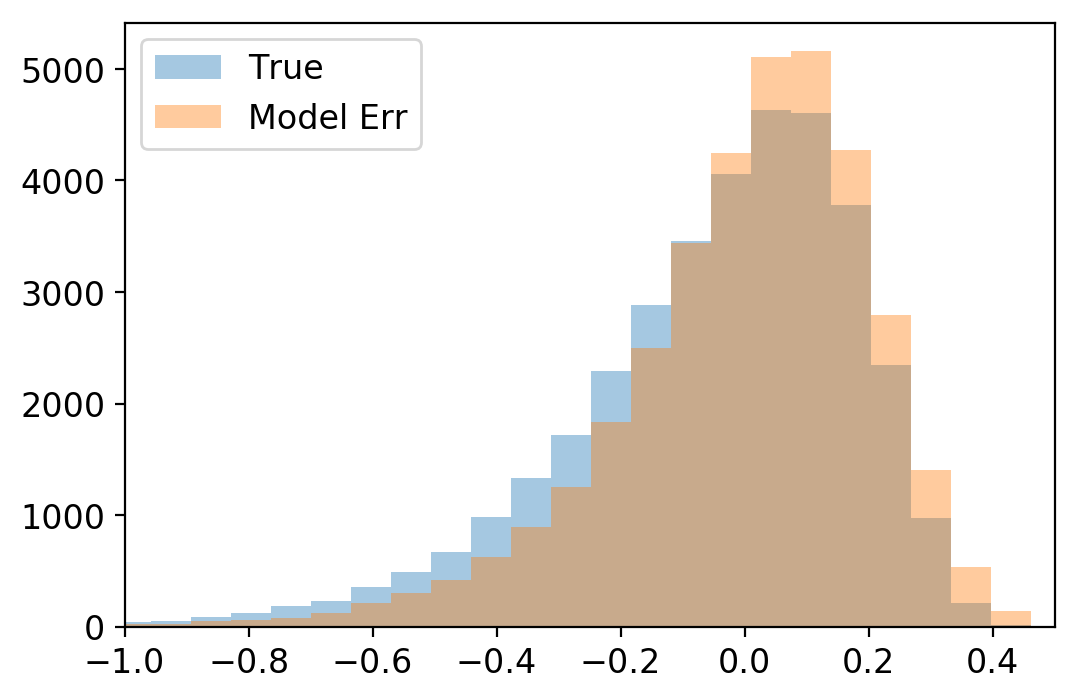

In [556]:
_, ax = plt.subplots()
#ax.hist(hcutz["cen_halo_sm_bias"], label="Truth")
y = hcutz["cen_halo_sm_bias"][g_vals]
x = np.array([hcutz["Halfmass_Scale"][g_vals], gammas2[g_vals], hcutz["scale_of_last_MM"][g_vals]]).T

cols = [i for i in list(hcutz) if "bias" not in i]
cols = ['Halfmass_Scale', 'scale_of_last_MM', 'gammas2', 'concentration', 'richness']
# best is 0.0789 (with cheating!)
# 0.1493 is best

print(cols)
x = hcutz[cols][g_vals]

    
# gammas2[g_vals],  


coef, intercept = p.physical_correlation_plots.linear_fit(x, y, "lasso")
print(coef, intercept)

coef, intercept = p.physical_correlation_plots.linear_fit(x, y, "least_squares")
for i in range(len(coef)):
    if coef[i] > 1e-4:
        print(cols[i], coef[i])
print(coef, intercept)


model = np.dot(x, coef) + intercept
model_err = y - model
print(np.std(model_err), np.std(y))

#ax.hist(model, alpha=0.4, label="Model", bins=20)
_, bins, _ = ax.hist(y, alpha=0.4, label="True", bins=35)
ax.hist(model_err, alpha=0.4, label="Model Err", bins=bins)
ax.set(xlim=(-1, 0.5))
ax.legend()

# # Is halo\* | vir fully explained by ???

['m', 'mp', 'sfr_cen', 'mvir', 'rvir', 'rs', 'Halfmass_Scale', 'scale_of_last_MM', 'M200b', 'M200c', 'Acc_Rate_Inst', 'Acc_Rate_100Myr', 'Acc_Rate_1*Tdyn', 'Acc_Rate_2*Tdyn', 'Acc_Rate_Mpeak', 'Vmax@Mpeak', 'sfr_halo', 'gammas1', 'gammas2', 'gammas3', 'concentration']
(35555, 21)


/home/christopher/.virtualenvs/hsc_um2/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/christopher/.virtualenvs/hsc_um2/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/christopher/.virtualenvs/hsc_um2/lib/python3.6/site-packages/numpy/lib/function_base.py:3183: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/christopher/.virtualenvs/hsc_um2/lib/python3.6/site-packages/numpy/lib/function_base.py:3184: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/christopher/.virtualenvs/hsc

[-1.71294436e-15  2.33087031e-16  6.94155123e-03 -3.29335443e-16 -3.35197489e-04 -1.42144248e-05  7.42361308e-02  1.92519348e-01 -5.36570923e-16  1.31047499e-15 -1.38883157e-07  4.50295118e-07 -5.99872426e-07  2.82523153e-06 -6.44825978e-06  3.14953568e-04  4.45622271e-03 -5.89403686e-03 -1.31315856e-02  1.78248935e-04 -8.63039822e-03] -0.01824281091162696
(35555, 21)
sfr_cen 0.0069792975677204225
Halfmass_Scale 0.07863347212999162
scale_of_last_MM 0.19253470949324308
Vmax@Mpeak 0.00029505633185894747
sfr_halo 0.004421685467052248
gammas3 0.00022886405049212237
[-3.82252648e-14  4.18046660e-16  6.97929757e-03  6.50747295e-14 -3.17949513e-04 -4.06391114e-05  7.86334721e-02  1.92534709e-01 -8.15427409e-15 -3.06447296e-15  3.83766273e-06 -3.57198309e-06 -2.47593912e-07  1.63211340e-06 -6.15134567e-06  2.95056332e-04  4.42168547e-03 -6.24806814e-03 -1.24520898e-02  2.28864050e-04 -8.68201520e-03] -0.018781341547055096
0.14933337935263757 0.1586969284677344
spearman
m -0.0678010065688696
mp

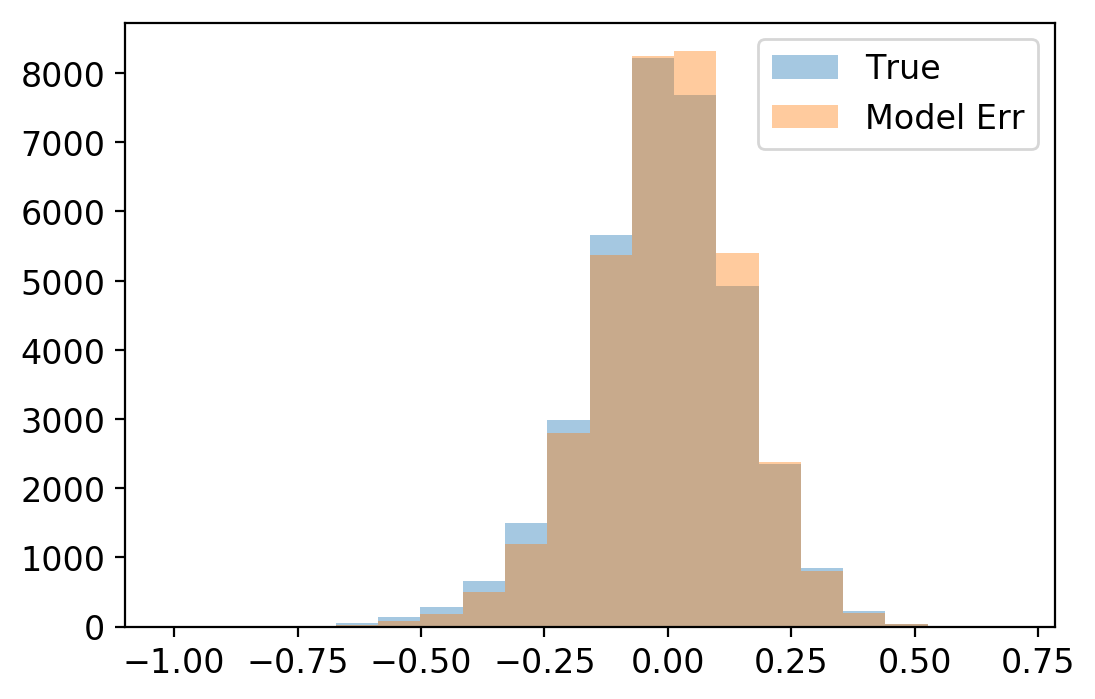

In [560]:
_, ax = plt.subplots()
#ax.hist(hcutz["cen_halo_sm_bias"], label="Truth")
y = hcutz["halo_sm_bias"][g_vals]
x = np.array([hcutz["Halfmass_Scale"][g_vals], gammas2[g_vals], hcutz["scale_of_last_MM"][g_vals]]).T

cols = ['m', 'mp', 'sfr_cen', 'mvir', 'rvir', 'rs', 'Halfmass_Scale', 'scale_of_last_MM', 'M200b', 'M200c', 'Acc_Rate_Inst', 'Acc_Rate_100Myr', 'Acc_Rate_1*Tdyn', 'Acc_Rate_2*Tdyn', 'Acc_Rate_Mpeak', 'Vmax@Mpeak', 'sfr_halo', 'gammas1', 'gammas2', 'gammas3', 'concentration']#, 'richness']
#cols = ['richness']
# best is 0.0789 (with cheating!)
# 0.1493 is best

print(cols)
x = hcutz[cols][g_vals]

coef, intercept = p.physical_correlation_plots.linear_fit(x, y, "lasso")
print(coef, intercept)

coef, intercept = p.physical_correlation_plots.linear_fit(x, y, "least_squares")
for i in range(len(coef)):
    if coef[i] > 1e-4:
        print(cols[i], coef[i])
print(coef, intercept)


model = np.dot(x, coef) + intercept
model_err = y - model
print(np.std(model_err), np.std(y))

#ax.hist(model, alpha=0.4, label="Model", bins=20)
_, bins, _ = ax.hist(y, alpha=0.4, label="UM", bins=20)
ax.hist(model_err, alpha=0.4, label="Model Err", bins=bins)

ax.legend()

print("spearman")
for col in list(hcutz):
    rho, _ = scipy.stats.spearmanr(hcutz["halo_sm_bias"], hcutz[col])
    if np.abs(rho) > 0.05:
        print(col, rho)

# Is halo* | vir scatter consistent with poisson scatter?

The scatter in halo\* | vir is the first component of our split scatter (the other being cen\* | halo\*). Could this scatter just be explained by Poisson noise?

To test this, we need to:
1. Look at the current scatter
2. Do some poisson resampling and see that scatter
3. Compare the two

Suggested way:
1. Make a thin cut in vir mass (can do this multiple times with different cuts to check that this isn't mass dependent)
2. Look at the scatter (s) in halo\* in that thin cut
3. Create a distribution (d) of all the satellite galaxies in the halos included in the cut
4. For each halo
    * Choose the number (n) of satellites it has by making a poisson draw with lambda = the number it has in reality
    * Choose n satellites from d
5. Having repopulated the halos with randomly selected sats, compute the scatter and compare it to (s)
6. If these two scatters are similar, claim that scatter in halo\* at fix vir is consistent with Poisson. This suggests that there is likely no (or a weak) physical explanation for the scatter.

Issues/Assumptions
1. I think we need to do this in a think mass cut as the satellite mass function definitely depends on the mass of the host halo.
    * We could probably work around this, but is simpler to just make the mass cut.
2. This assumes that satellites can be populated by IID selection. I'm not sure this is true. I think there is probably some conditional dependence.
    * e.g. if one of the satellites has its own satellites?
    * Could we check whether this is a big deal by just doing the resampling without doing the poisson draw? If the scatter is the same, this is OK?
3. This doesn't actually prove that there isn't underlying method to the apparent randomness. That method could just give the same scatter as randomness.
    * This was Peter's point.
    * Should we be checking more than just the distribution of scatters?

In [523]:
cuts = (10**13.6, 10**13.63)
cut_sample_halo = data_halo_cut["halo"]["data"][(data_halo_cut["halo"]["data"]["m"] > cuts[0]) & (data_halo_cut["halo"]["data"]["m"] < cuts[1])]
cut_sample_cen = data_halo_cut["cen"]["data"][(data_halo_cut["cen"]["data"]["m"] > cuts[0]) & (data_halo_cut["cen"]["data"]["m"] < cuts[1])]
assert np.all(cut_sample_cen["id"] == cut_sample_halo["id"])
ids = cut_sample_halo["id"]
print(len(ids))

uncut_sat_sample = satellites[np.isin(satellites["upid"], ids)]
uncut_num_sats = np.array([np.count_nonzero(uncut_sat_sample["upid"] == idx) for idx in ids])
uncut_num_sats_wo_icl = (uncut_num_sats + cut_sample_cen["icl"]/np.mean(uncut_sat_sample["icl"] + uncut_sat_sample["sm"])).astype(np.int)



sat_sample = uncut_sat_sample[uncut_sat_sample["sm"] + uncut_sat_sample["icl"] > 1e7]
num_sats = np.array([np.count_nonzero(sat_sample["upid"] == idx) for idx in ids])

# Most massive satellite in the halo i.e. most_massive_sats[0] contains a list of all the largest 
# sats in their halos, most_massive_sats[1] contains all the second most, etc
most_massive_sats = [] 
for i in range(1, 16):
    most_massive_sats.append(np.array([np.sort(sat_sample[sat_sample["upid"] == idx]["sm"] + sat_sample[sat_sample["upid"] == idx]["icl"])[-i] for idx in ids]))
    
largest = np.log10([np.max(sat_sample[sat_sample["upid"] == idx]["sm"] + sat_sample[sat_sample["upid"] == idx]["icl"]) for idx in ids])
assert np.all(np.log10(most_massive_sats[0]) == largest)

total_sat_mass = np.log10([np.sum(sat_sample[sat_sample["upid"] == idx]["sm"] + sat_sample[sat_sample["upid"] == idx]["icl"]) for idx in ids])

610


In [525]:
origin_scatter.rollup.build_sat_tree(uncut_sat_sample, ids)

rolled_up_sat_sample, rolled_up_num_sats = origin_scatter.rollup.rollup(uncut_sat_sample, ids)
rolled_up_num_sats_wo_icl = (rolled_up_num_sats + cut_sample_cen["icl"]/np.mean(rolled_up_sat_sample["icl"] + rolled_up_sat_sample["sm"])).astype(np.int)


print(np.sum(rolled_up_sat_sample["sm"] + rolled_up_sat_sample["icl"]))
print(np.sum(uncut_sat_sample["sm"] + uncut_sat_sample["icl"]))
print("These are now so close that we don't need to build a fake halo mass only including these sats")

{'total': 130275, 'nth': [89739, 26243, 6251, 1395, 296, 64, 11, 2, 0], 'orphan': 4683, 'not_found': 1591, 'well_found': 124001}
0
{'total': 14.41238946035583, 'nth': array([14.15384741, 13.56082315, 12.8392214 , 11.94825941, 11.54117975, 10.90907254,  8.29713266,  7.07680059,        -inf]), 'orphan': 13.84623797709069, 'not_found': 12.065856987465363, 'well_found': 14.272096931219945}


/home/christopher/research/hsc_um2/cb/origin_scatter/rollup.py:94: RuntimeWarning: divide by zero encountered in log10
  print({k: np.log10(v) for k, v in sm.items()})


257293948391589.53
258457691139119.9
These are now so close that we don't need to build a fake halo mass only including these sats


## Simplest idea - just random sampling

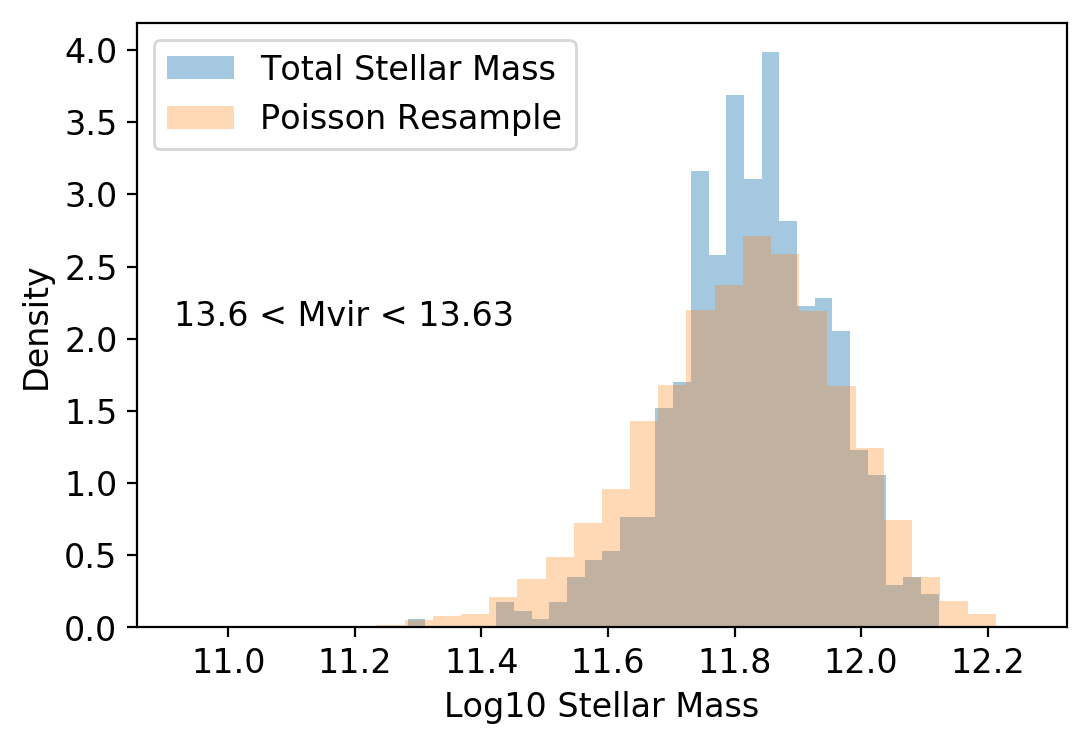

In [579]:
# Scatter in the current data set
_, ax = plt.subplots()
mass = np.log10(cut_sample_halo["sm"] + cut_sample_halo["icl"])
_, bins, _ = ax.hist(mass, bins=30, alpha=0.4, label="Total Stellar Mass", density=True)

# Scatter in the resampled data set
full_poisson_masses, half_poisson_masses = origin_scatter.resample.resample_sats(cut_sample_cen, uncut_sat_sample, uncut_num_sats)

ax.hist(full_poisson_masses, bins=30, alpha=0.3, label="Poisson Resample", density=True)
#ax.hist(half_poisson_masses, bins=30, alpha=0.3, label="Half Poisson scatter", density=True)
ax.set(
    xlabel="Log10 Stellar Mass",
    ylabel="Density",
)
ax.annotate(xy=(0.04, 0.5), s="13.6 < Mvir < 13.63", xycoords="axes fraction")
ax.legend()

## Random sample per sub halo

Rather than sample from the full galaxy population (where there are **strong** conditional probablility because there are satellites of satellites), sample from the population of subhalos. So, sum all the stellar mass in a subhalo and call that 1 satellite.

This will have much weaker conditional probabilities as while there is large scale structure correlations I'm pretty sure this is weaker than the correlation of galaxies in the same halo.

In [ ]:
# We don't have all the mass, only the well formed portion. This is ~70% of mass
_, ax = plt.subplots()
mass = np.log10(cut_sample_halo["sm"] + cut_sample_halo["icl"])
_, bins, _ = ax.hist(mass, bins=30, alpha=0.4, label="True scatter", density=True)

mass =  np.log10(rolled_up_cut_sample_halo["sm"] + rolled_up_cut_sample_halo["icl"])
_, bins, _ = ax.hist(mass, bins=30, alpha=0.4, label="Rolled up scatter", density=True)

In [ ]:
# Scatter in the current data set
_, ax = plt.subplots()
mass = np.log10(rolled_up_cut_sample_halo["sm"] + rolled_up_cut_sample_halo["icl"])
_, bins, _ = ax.hist(mass, bins=30, alpha=0.4, label="True scatter", density=True)

# Scatter in the resampled data set
full_poisson_masses, half_poisson_masses = origin_scatter.resample.resample_sats(cut_sample_cen, rolled_up_sat_sample, rolled_up_num_sats)

ax.hist(full_poisson_masses, bins=30, alpha=0.3, label="Poisson scatter", density=True)
ax.hist(half_poisson_masses, bins=30, alpha=0.3, label="Half Poisson scatter", density=True)

ax.legend()

## These two combined

0.12115812488993379 0.15819548534169395 0.17168830961482404


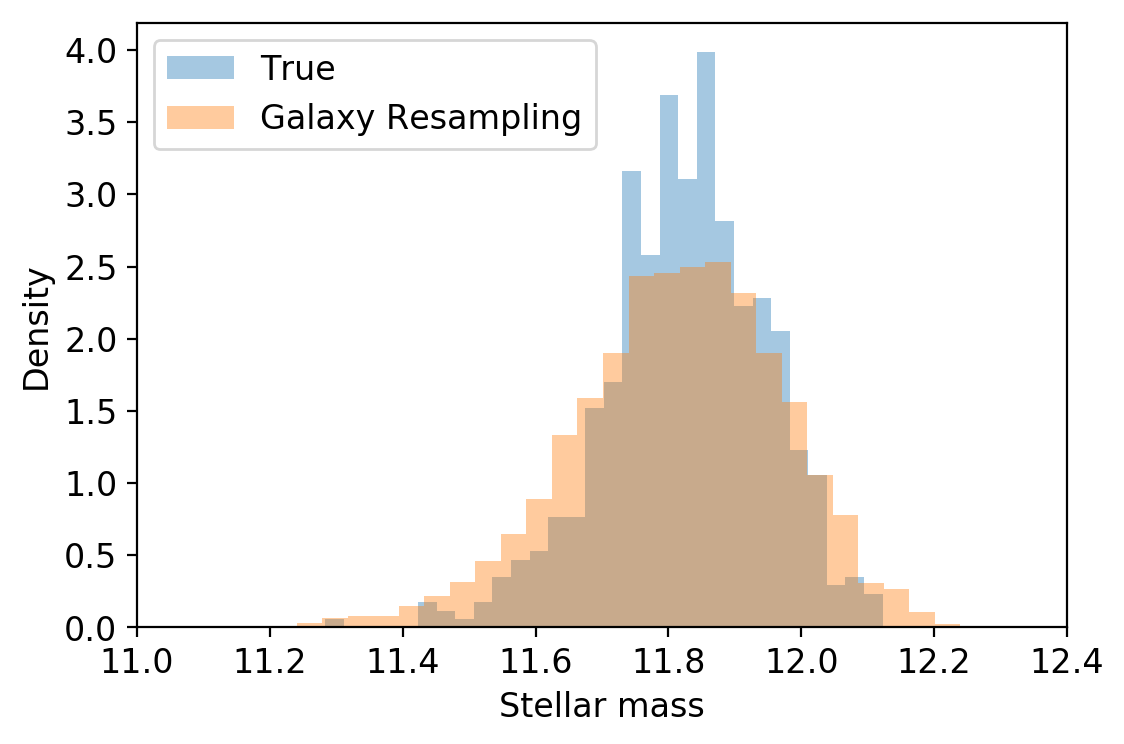

In [573]:
_, ax = plt.subplots()
# True scatter
actual_mass = np.log10(cut_sample_halo["sm"] + cut_sample_halo["icl"])
_, bins, _ = ax.hist(actual_mass, bins=30, alpha=0.4, label="True", density=True)

# Using the simple resampling
full_poisson_masses_galaxy, _ = origin_scatter.resample.resample_sats(cut_sample_cen, uncut_sat_sample, uncut_num_sats)
ax.hist(full_poisson_masses_galaxy, bins=30, alpha=0.4, label="Galaxy Resampling", density=True)

# Simple resampling wo icl
#full_poisson_masses_galaxy, _ = origin_scatter.resample.resample_sats(cut_sample_cen, uncut_sat_sample, uncut_num_sats_wo_icl, incl_icl=False)
#ax.hist(full_poisson_masses_galaxy, bins=30, alpha=0.4, label="Galaxy Resampling wo icl", density=True)

# True rollup scatter (so missing 0.5% of mass
#mass = np.log10(rolled_up_cut_sample_halo["sm"] + rolled_up_cut_sample_halo["icl"])
#_, bins, _ = ax.hist(mass, bins=30, alpha=0.4, label="True scatter", density=True)

# rollup resampling
#full_poisson_masses_halo, _ = origin_scatter.resample.resample_sats(cut_sample_cen, rolled_up_sat_sample, rolled_up_num_sats)
#ax.hist(full_poisson_masses_halo, bins=30, alpha=0.4, label="Halo Resampling", density=True)

# rollup resanpling wo icl
#full_poisson_masses_halo, _ = origin_scatter.resample.resample_sats(cut_sample_cen, rolled_up_sat_sample, rolled_up_num_sats_wo_icl, incl_icl=False)
#ax.hist(full_poisson_masses_halo, bins=30, alpha=0.4, label="Halo Resampling wo ICL", density=True)


# axis etc
ax.legend(loc="upper left")
ax.set(
    xlabel="Stellar mass",
    ylabel="Density",
    xlim=(11, 12.4),
)



print(np.std(actual_mass), np.std(full_poisson_masses_galaxy), np.std(full_poisson_masses_halo))

1.9071622735654805 1.8545661395373871
6.339635848190221 6.361207714705441
94422 130275


ValueError: operands could not be broadcast together with shapes (14313,) (610,) 

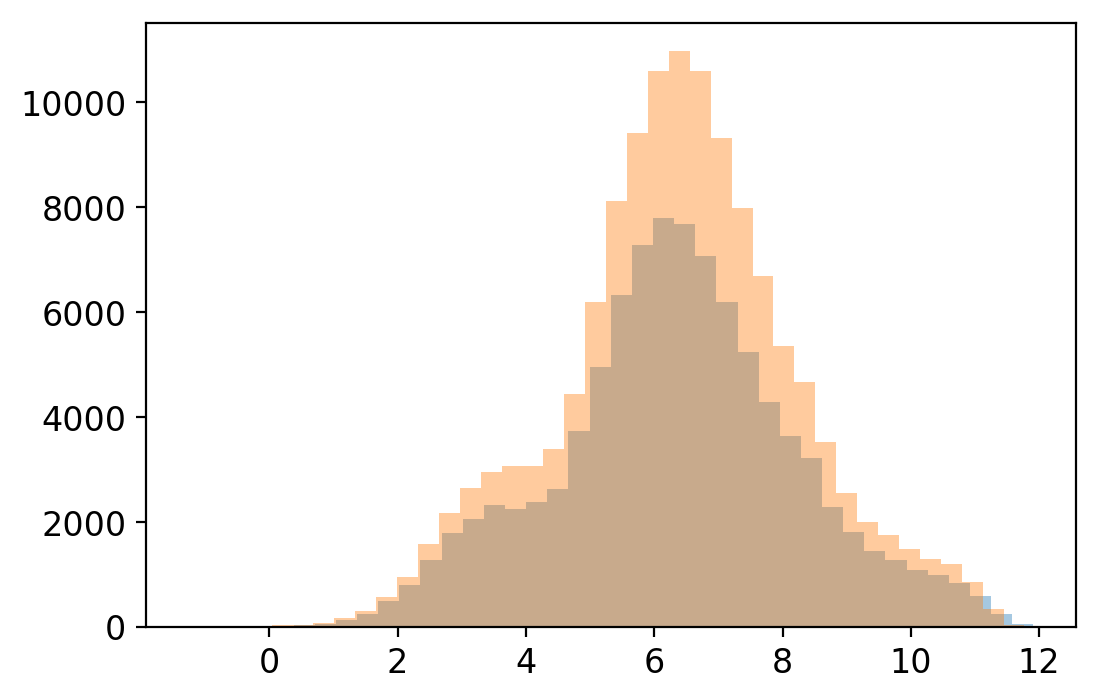

In [570]:
# OK I don't understand this
russ = np.log10(rolled_up_sat_sample["sm"] + rolled_up_sat_sample["icl"])
uss = np.log10(uncut_sat_sample["sm"] + uncut_sat_sample["icl"])
plt.hist(russ, bins=40, alpha=0.4)
plt.hist(uss, bins=40, alpha=0.4)
print(np.std(russ), np.std(uss))
print(np.mean(russ), np.mean(uss))
print(len(russ), len(uss))
# Ok so uss has a slightly lower

sat_mass = rolled_up_cut_sample_halo["sm"] + rolled_up_cut_sample_halo["icl"] - cut_sample_cen["sm"] - cut_sample_cen["icl"]
_, ax = plt.subplots()
ax.scatter(np.log10(sat_mass), rolled_up_num_sats)
_, _, r, _, _ = scipy.stats.linregress(np.log10(sat_mass), rolled_up_num_sats)
print(r)

sat_mass = cut_sample_halo["sm"] + cut_sample_halo["icl"] - cut_sample_cen["sm"] - cut_sample_cen["icl"]
_, ax = plt.subplots()
ax.scatter(np.log10(sat_mass), uncut_num_sats)
_, _, r, _, _ = scipy.stats.linregress(np.log10(sat_mass), uncut_num_sats)
print(r)

## This doesn't make sense

I would expect that going from samling from things that are correlated to things that are uncorrelated should be more similar to the truth. In fact we see the opposite. Why?

In [ ]:
# SM and ICL are not correlated in the central
x = scipy.stats.linregress(np.log10(cut_sample_cen["icl"]), np.log10(cut_sample_cen["sm"]))
print("SM and ICL correlation: ", x)

# Merged and non merged are negatively correlated
x = scipy.stats.linregress(np.log10(cut_sample_cen["icl"]), np.log10(cut_sample_halo["icl"] + cut_sample_halo["sm"] - cut_sample_cen["icl"] - cut_sample_cen["sm"]))
print("Non merged ICL and merged ICL correlation: ", x)
plt.scatter(np.log10(cut_sample_cen["icl"]), np.log10(cut_sample_halo["icl"] + cut_sample_halo["sm"] - cut_sample_cen["icl"] - cut_sample_cen["sm"]))

In [ ]:
# Are galaxies in a halo more or less similar to each other than the full sample of galaxies?
pids, pid_counts = np.unique(uncut_sat_sample["pid"], return_counts=True)
pid_order = np.argsort(pid_counts)[::-1]
pid_counts = pid_counts[pid_order]
pids = pids[pid_order]

all_std, sub_std, mean_diff = [], [], []


for pid in pids:
    sub_sats = uncut_sat_sample[uncut_sat_sample["pid"] == pid]
    if len(sub_sats) < 100: break
    all_sub_sats = uncut_sat_sample[uncut_sat_sample["upid"] == sub_sats[0]["upid"]]
    
    sub_sats = np.log10(sub_sats["sm"] + sub_sats["icl"])
    all_sub_sats = np.log10(all_sub_sats["sm"] + all_sub_sats["icl"])
    
    all_std.append(np.std(all_sub_sats))
    sub_std.append(np.std(sub_sats))
    mean_diff.append(np.mean(all_sub_sats) - np.mean(sub_sats))

print(np.std(np.log10(uncut_sat_sample["sm"] + uncut_sat_sample["icl"])))
print(np.mean(all_std))
print(np.mean(sub_std))
plt.hist(mean_diff, bins=50)

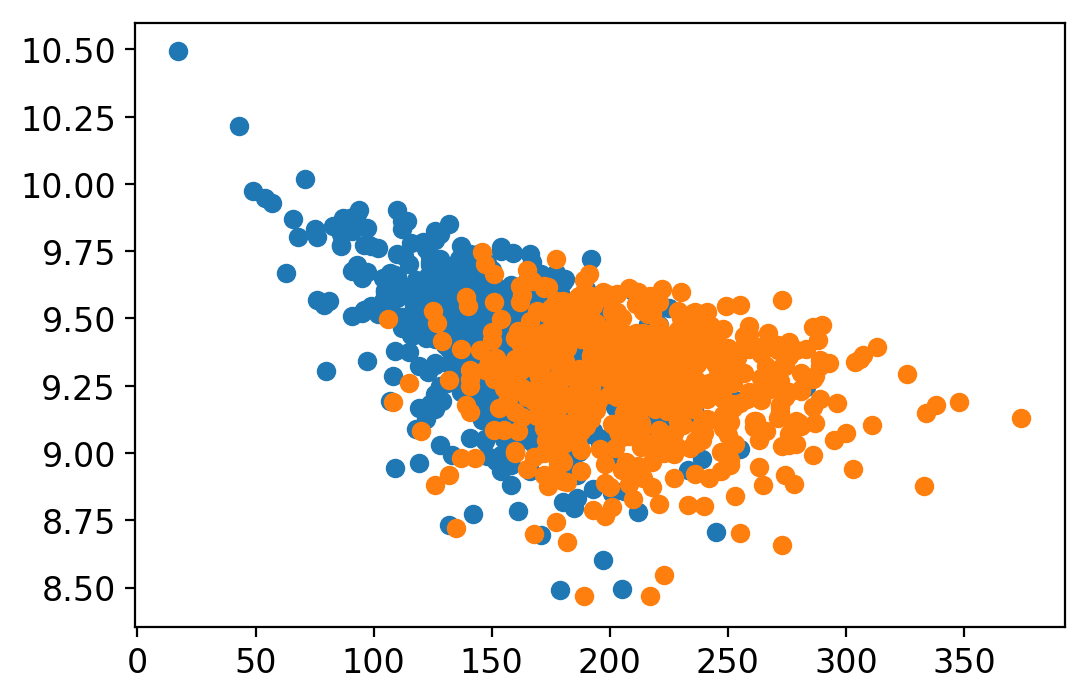

## Random sampling per sat from similarly rich clusters

Ks_2sampResult(statistic=0.05934426229508205, pvalue=0.034152023275526903)


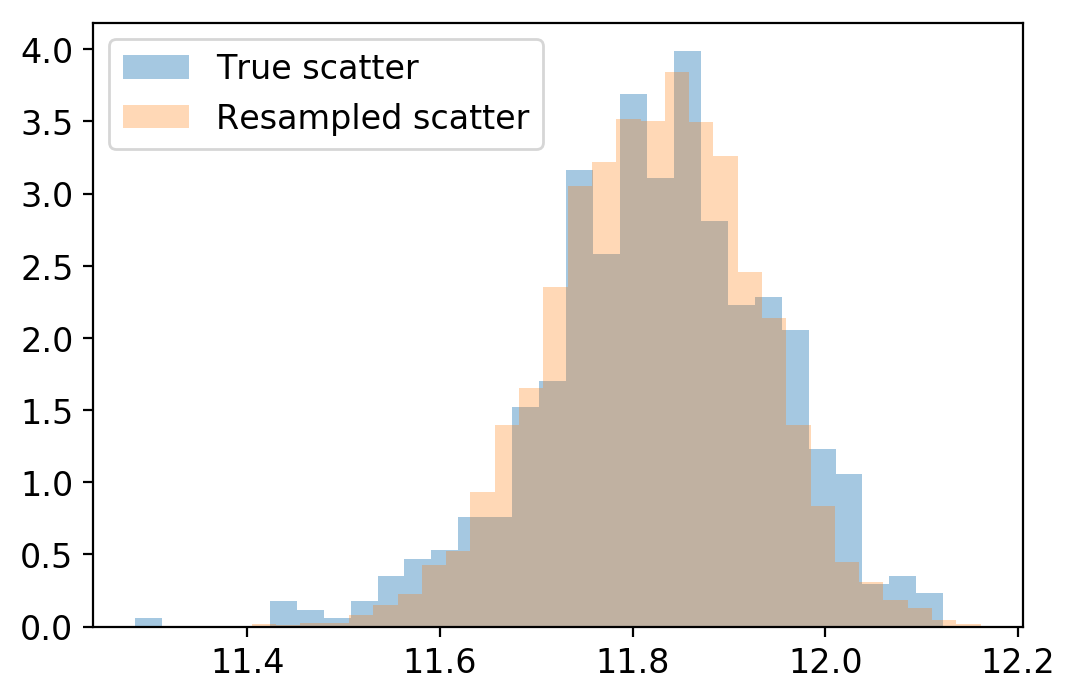

In [487]:
# I think this is silly. Yes scatter is similar, but that is just statistics.
# Scatter in the current data set
_, ax = plt.subplots()
basic_scatter = np.log10(cut_sample_halo["sm"] + cut_sample_halo["icl"])
_, bins, _ = ax.hist(basic_scatter, bins=30, alpha=0.4, label="True scatter", density=True)

# Scatter in the resampled data set
half_poisson_masses, full_poisson_masses = [], []
for i in range(len(cut_sample_cen)):
    for _ in range(15):
        mass = cut_sample_cen[i]["sm"] + cut_sample_cen[i]["icl"]
        this_richness = num_sats[i]
        similarly_rich_indexes = (num_sats < 1.1*this_richness) & (num_sats > this_richness*0.9)
        for sat in range(15):
            mass += np.random.choice(most_massive_sats[sat][similarly_rich_indexes])
        half_poisson_masses.append(np.log10(mass))
        """
        mass = cut_sample_cen[i]["sm"] + cut_sample_cen[i]["icl"]
        for sat in range(15):
            mass += np.sum(np.random.choice(most_massive_sats[sat][similarly_rich_indexes], np.random.poisson(1)))
        full_poisson_masses.append(np.log10(mass))
        """
ax.hist(half_poisson_masses, bins=30, alpha=0.3, label="Resampled scatter", density=True)
#ax.hist(full_poisson_masses, bins=30, alpha=0.3, label="Resampled scatter w/ Poisson", density=True)
print(scipy.stats.ks_2samp(half_poisson_masses, basic_scatter))
ax.legend()

## Random resampling from similar richness without Nth

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
0 14313


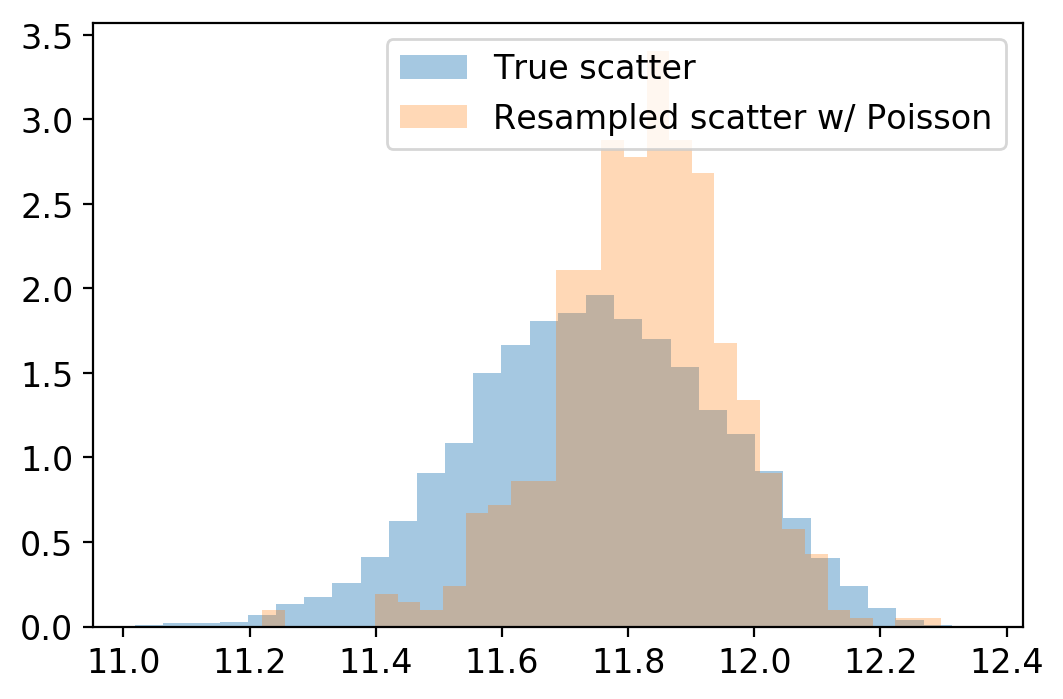

In [514]:
# We need to make sure we are staying the halo mass cut
cuts2 = (10**13.6, 10**13.63)
cut_sample_halo2 = data_halo_cut["halo"]["data"][(data_halo_cut["halo"]["data"]["m"] > cuts[0]) & (data_halo_cut["halo"]["data"]["m"] < cuts[1])]

_, ax = plt.subplots()
basic_scatter = np.log10(cut_sample_halo2["sm"] + cut_sample_halo2["icl"])
_, bins, _ = ax.hist(basic_scatter, bins=30, alpha=0.4, label="True scatter", density=True)


# Scatter in the resampled data set
avg_intersect = []
half_poisson_masses, full_poisson_masses = [], []
post_resample_halo_masses = []
for i in range(len(cut_sample_cen)):
    if i % 100 == 0: print(i)
    while True:
        original_richness = rolled_up_num_sats[i]
        original_sats = rolled_up_sat_sample[rolled_up_sat_sample["upid"] == ids[i]]

        similarly_rich_indexes = (rolled_up_num_sats < 1.1*original_richness) & (rolled_up_num_sats > 0.9*original_richness)
        similarly_massed_indexes = (cut_sample_cen["m"] < 1.1*cut_sample_cen["m"][i]) & (cut_sample_cen["m"] > 0.9*cut_sample_cen["m"][i]) 
        similarly_rich_pids = ids[similarly_rich_indexes & similarly_massed_indexes]
        if len(similarly_rich_pids) < 10: 
            break # give up

        allowed_sats = rolled_up_sat_sample[np.isin(rolled_up_sat_sample["upid"], similarly_rich_pids)]
        num_draws = np.random.poisson(original_richness)

        chosen_sats = np.random.choice(allowed_sats, num_draws)

        additional_hm = np.sum(chosen_sats["mp"])
        original_additional_hm = np.sum(original_sats["mp"])
        post_resample_halo_mass = cut_sample_cen[i]["m"] - original_additional_hm + additional_hm
        post_resample_halo_masses.append(post_resample_halo_mass)
        #if (post_resample_halo_mass  > 10**13.63) or (post_resample_halo_mass < 10**13.6):
        #    continue # try again

        avg_intersect.append(len(np.intersect1d(chosen_sats["id"], original_sats["id"])) / len(original_sats))
        mass = np.sum(chosen_sats["sm"] + chosen_sats["icl"]) + cut_sample_cen[i]["sm"] + cut_sample_cen[i]["icl"]
        full_poisson_masses.append(np.log10(mass))
        break

post_resample_halo_masses = np.array(post_resample_halo_masses)
full_poisson_masses = np.array(full_poisson_masses)

good_out_idx = (post_resample_halo_masses > cuts2[0]) & (post_resample_halo_masses < cuts2[1])
        
print(failed, len(cut_sample_cen))
#ax.hist(half_poisson_masses, bins=30, alpha=0.3, label="Resampled scatter", density=True)
ax.hist(full_poisson_masses[good_out_idx], bins=30, alpha=0.3, label="Resampled scatter w/ Poisson", density=True)
#print(scipy.stats.ks_2samp(half_poisson_masses, basic_scatter))
ax.legend()

0 610


[Text(0.5,0,'SM')]

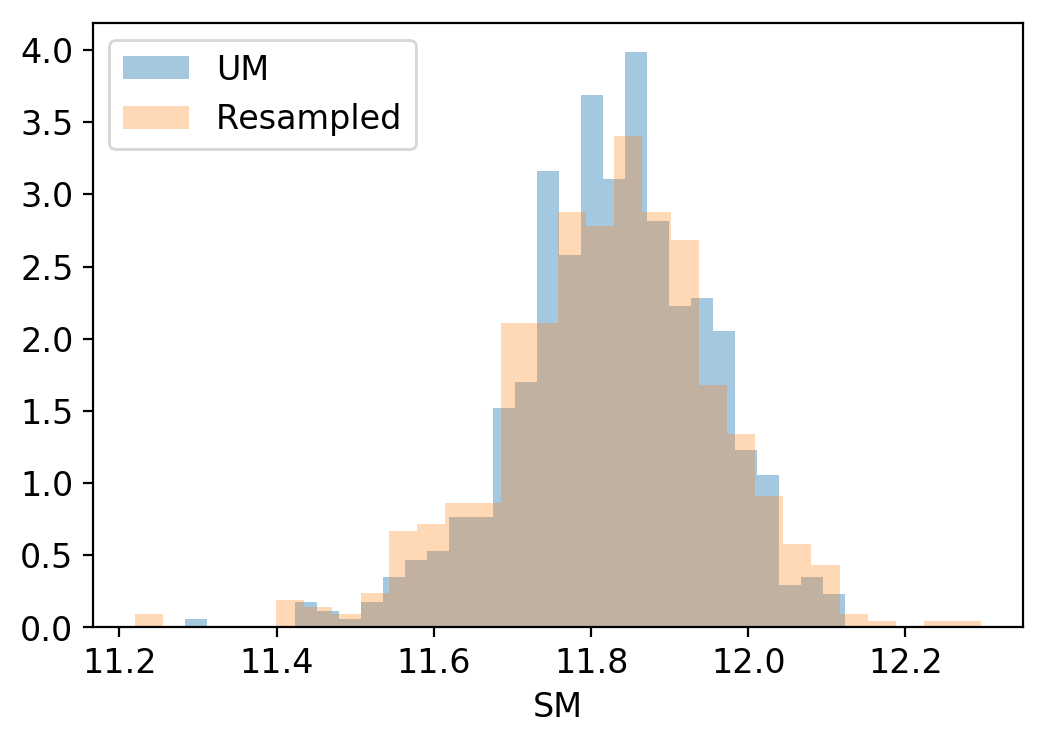

In [568]:
_, ax = plt.subplots()
cuts2 = (10**13.6, 10**13.63)
cut_sample_halo2 = data_halo_cut["halo"]["data"][(data_halo_cut["halo"]["data"]["m"] > cuts2[0]) & (data_halo_cut["halo"]["data"]["m"] < cuts2[1])]
basic_scatter = np.log10(cut_sample_halo2["sm"] + cut_sample_halo2["icl"])
_, bins, _ = ax.hist(basic_scatter, bins=30, alpha=0.4, label="UM", density=True)

good_out_idx = (post_resample_halo_masses > cuts2[0]) & (post_resample_halo_masses < cuts2[1])
      
print(failed, len(cut_sample_cen))
#ax.hist(half_poisson_masses, bins=30, alpha=0.3, label="Resampled scatter", density=True)
ax.hist(full_poisson_masses[good_out_idx], bins=30, alpha=0.3, label="Resampled", density=True)
#print(scipy.stats.ks_2samp(half_poisson_masses, basic_scatter))
ax.legend(loc="upper left")
ax.set(xlabel= "SM")

## The above doesn't work because our sampling model is too simple. Let's play with things

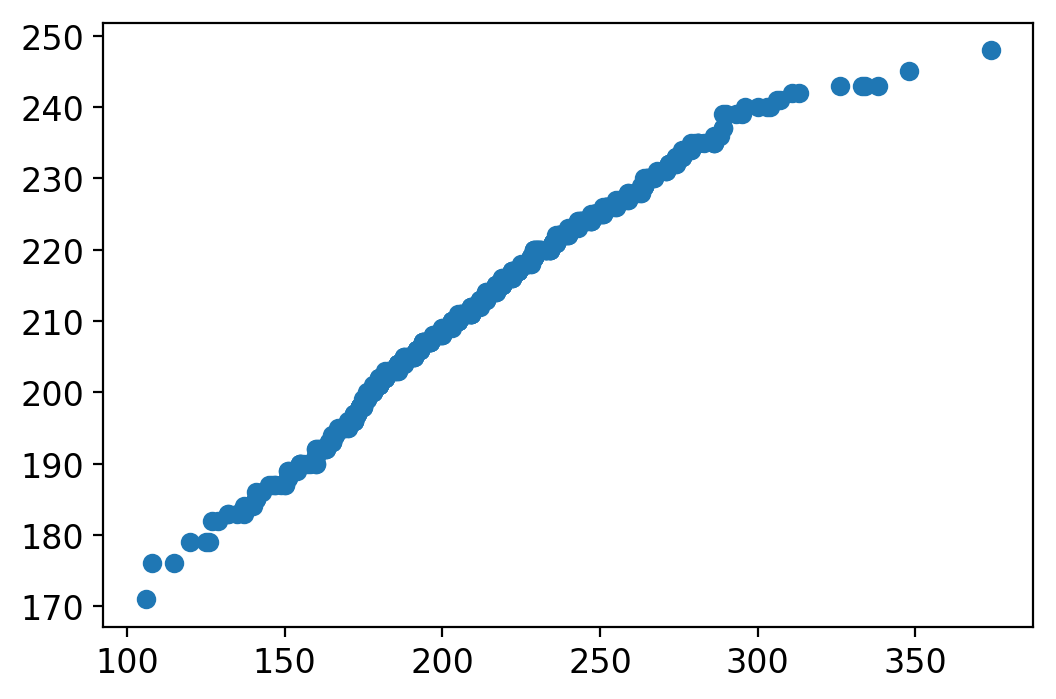

In [541]:
# Is the num ~ a poisson draw?
actual = rolled_up_num_sats
mean = np.mean(actual)
poisson = np.random.poisson(mean, len(actual))
plt.scatter(np.sort(actual), np.sort(poisson))

Text(0.05,0.8,'Slope = 0.001\nIntercept = 10.89\nR = 0.15')

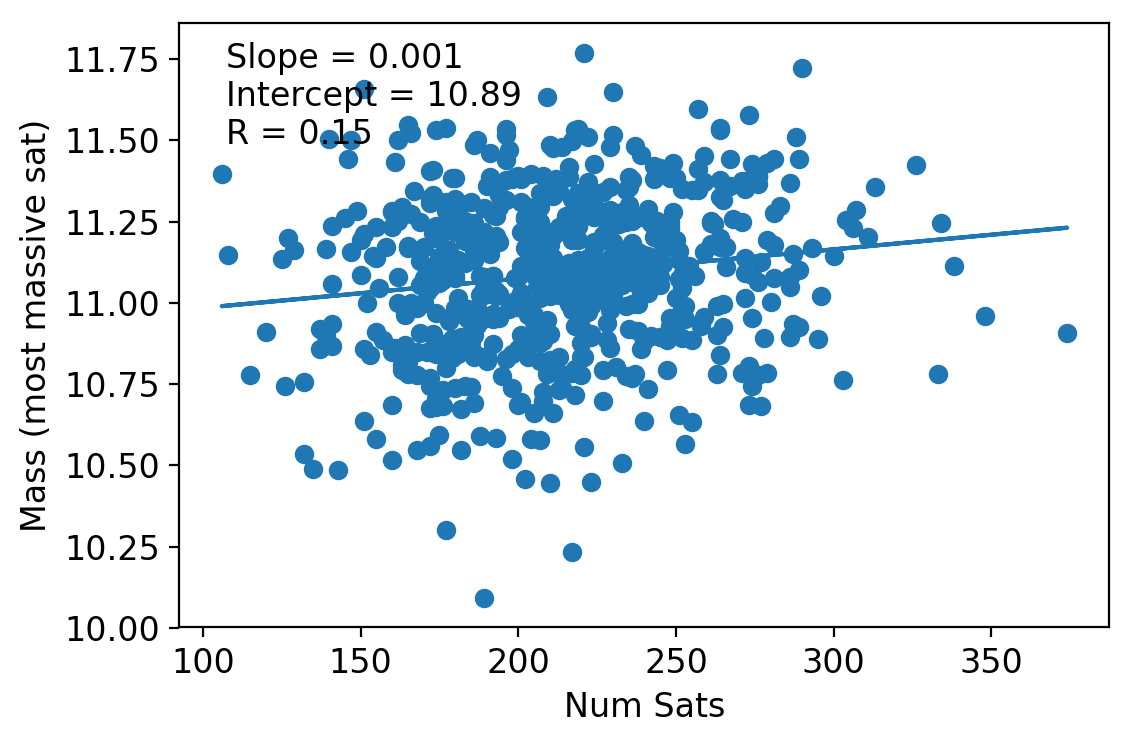

In [530]:
## Correlation between richness and max sat mass
_, ax = plt.subplots()

x, xlabel = uncut_num_sats, "Num Sats"
y, ylabel = largest, "Mass (most massive sat)"

ax.scatter(x, y)
reg = scipy.stats.linregress(x, y)
ax.plot(x, reg.slope*x + reg.intercept)
ax.set(
    xlabel=xlabel,
    ylabel=ylabel,
)
ax.annotate(xy=(0.05, 0.8), xycoords="axes fraction", s="Slope = {:.3f}\nIntercept = {:.2f}\nR = {:.2f}".format(reg.slope, reg.intercept, reg.rvalue))

Text(0.05,0.8,'Slope = 0.662\nIntercept = 4.24\nR = 0.79')

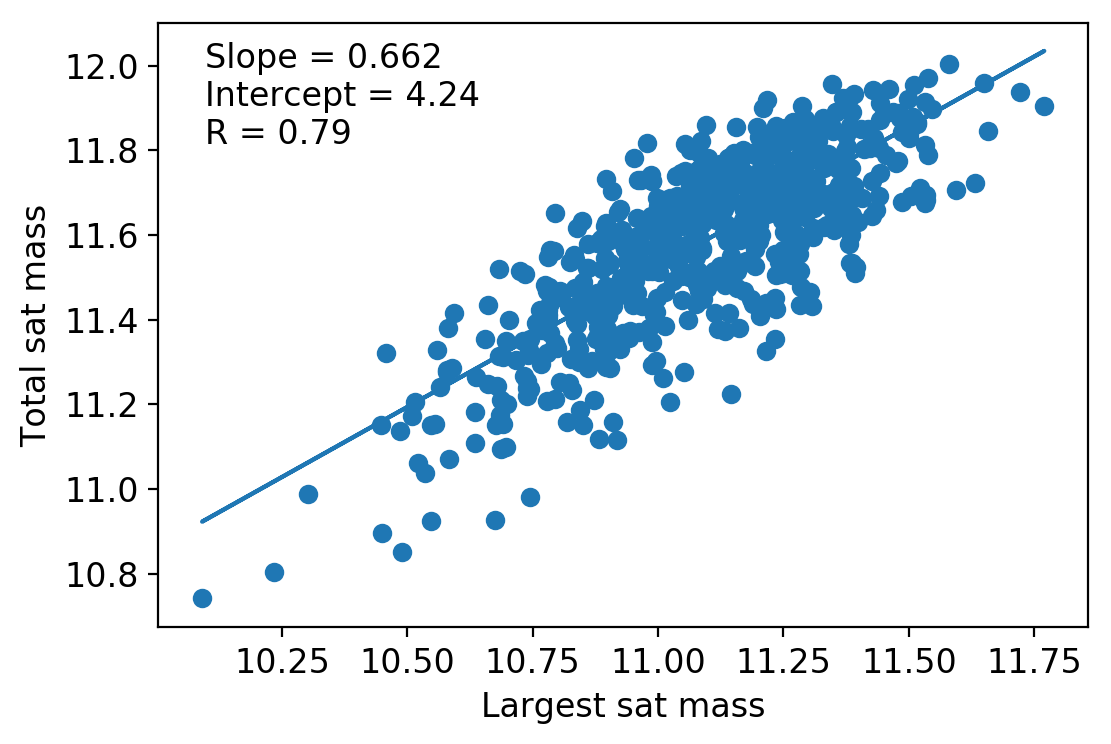

In [532]:
_, ax = plt.subplots()

y, ylabel = total_sat_mass, "Total sat mass"
x, xlabel = largest, "Largest sat mass"

ax.scatter(x, y)
reg = scipy.stats.linregress(x, y)
ax.plot(x, reg.slope*x + reg.intercept)
ax.set(
    xlabel=xlabel,
    ylabel=ylabel,
)
ax.annotate(xy=(0.05, 0.8), xycoords="axes fraction", s="Slope = {:.3f}\nIntercept = {:.2f}\nR = {:.2f}".format(reg.slope, reg.intercept, reg.rvalue))

LinregressResult(slope=5.496107883715631e-05, intercept=6.3361830590476345, rvalue=0.008862641840572297, pvalue=0.8270812963471618, stderr=0.00025149143773190607)
SpearmanrResult(correlation=0.013836753613237256, pvalue=0.7330599347394834)
LinregressResult(slope=-0.001471109265340465, intercept=6.716134427719981, rvalue=-0.33703054494147977, pvalue=1.1422084508607125e-17, stderr=0.00016666380889238046)
SpearmanrResult(correlation=-0.3077592419836417, pvalue=7.545186632721818e-15)


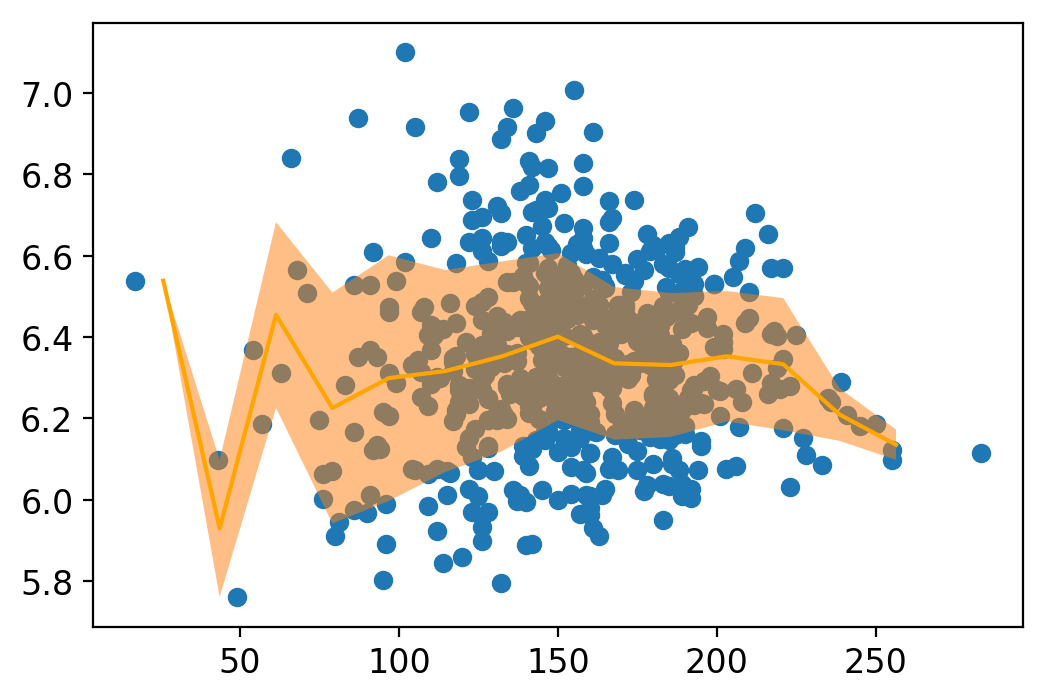

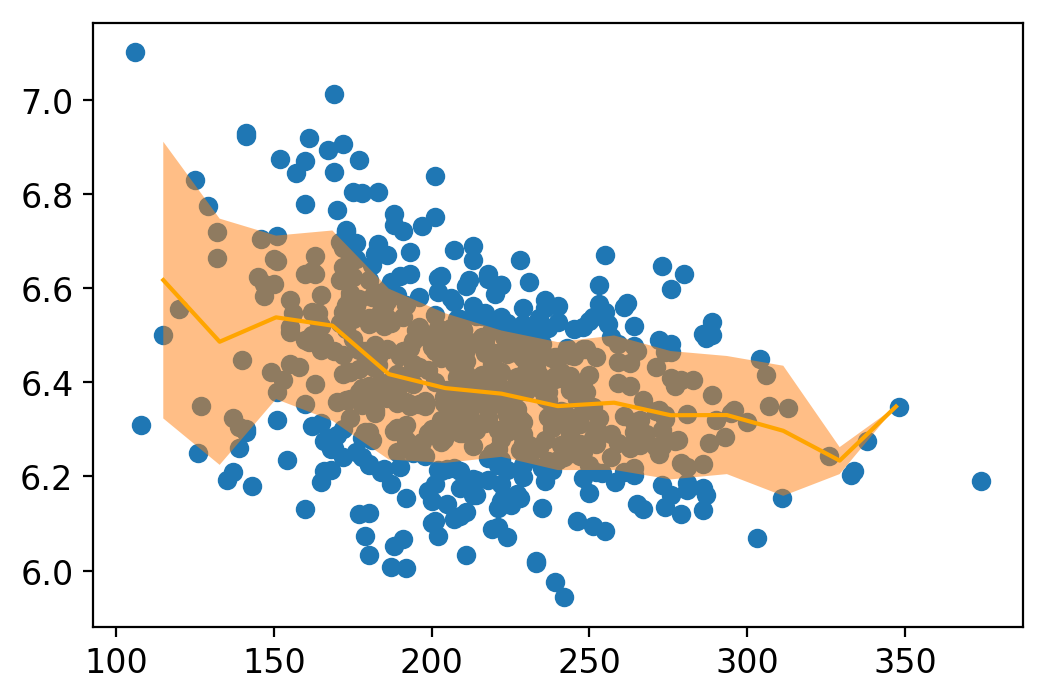

In [539]:
# Does the number of satellites correlate with the average mass?
for sample in [rolled_up_sat_sample, uncut_sat_sample]:
    nums = np.array([np.count_nonzero(sample["upid"] == idx) for idx in ids]) # rolled_up_num_sats
    mean_masses = np.array([np.median(sample[sample["upid"] == idx]["icl"] + sample[sample["upid"] == idx]["sm"]) for idx in ids])
    

    p.general_scatter.linear(nums, np.log10(mean_masses))

# What could cause the scatter in the SMHR?

## Lasso to find the best linear model

In [ ]:
weights, intercept = p.physical_correlation_plots.lasso(data_halo_cut["cen"])
print(weights, intercept)

In [ ]:
p.physical_correlation_plots.lasso(data_halo_cut["halo"])

## Correlation plots

In [ ]:
# I need to redo these to do the two components
p.physical_correlation_plots.correlation_matrix(data_halo_cut["cen"])
p.physical_correlation_plots.correlation_matrix(data_halo_cut["halo"])
p.physical_correlation_plots.cen_vs_halo_correlation_matrix(data_halo_cut["cen"], data_halo_cut["halo"])
p.physical_correlation_plots.marginalized_heatmap(data_halo_cut["cen"])

## Use best model to predict SM bias

In [ ]:
p.physical_correlation_plots.margin_model(data_halo_cut["cen"])

In [ ]:
p.physical_correlation_plots.margin_model(data_halo_cut["halo"])

In [ ]:
p.physical_correlation_plots.best_model(data_halo_cut["cen"])

# Concentration - is that correlated with over/undermassive halos

Same as richness but for concentration

In [ ]:
p.physical_correlation_plots.sm_at_fixed_hm_conc_split(data_halo_cut["cen"])

In [ ]:
p.physical_correlation_plots.conc_sm_heatmap_at_fixed_hm(data_halo_cut["cen"])

# Age

What about age?

# Comparison of secondary feature distribution

Let's look at how a selection on stellar mass could bias the secondary features.
1. Select a sample by cutting on some variant of SM
2. Select a sample by matching the halo mass distribution of 1
3. Compare features of 1 and 2

## Concentration

In [ ]:
cen_cuts = (11.9, 12.1)
halo_cuts = tuple(fits.mass_at_density(data_stellar_cut, "halo", fits.density_at_mass(
        data_stellar_cut, "cen", m)) for m in cen_cuts)
print("central cuts of {}, halo cuts of {}".format(cen_cuts, halo_cuts))

fig = plt.figure()
big_ax = fig.add_subplot(111)
big_ax.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off') 
big_ax.grid(False)                                                                      

axes = [fig.add_subplot(121), fig.add_subplot(122)]
axes[1].set_yticks([])
fig.subplots_adjust(wspace=0, hspace=0)

f = p.same_hm_dist_plots.f_concentration
p.same_hm_dist_plots.plot_pdf(data_stellar_cut, data_halo_cut, "cen", f, cuts=cen_cuts, ax=axes[0], bins=12)
p.same_hm_dist_plots.plot_pdf(data_stellar_cut, data_halo_cut, "halo", f, cuts=halo_cuts, ax=axes[1], bins=12)

big_ax.set(**{"xlabel": "Concentration"})
axes[0].set(**{"ylabel": "Density"})
for ax in [axes[0], axes[1]]:
    ax.set(**{"xlim": (0, max(axes[0].get_xlim()[1], axes[1].get_xlim()[1])), 
              "ylim": (0, max(axes[0].get_ylim()[1], axes[1].get_ylim()[1]))})

In [ ]:
p.same_hm_dist_plots.plot_cdf(data_stellar_cut, data_halo_cut, "halo", p.same_hm_dist_plots.f_concentration, cuts=halo_cuts)

## Median shift

In [ ]:
for f_name in ["f_concentration","f_age", "f_mm", "f_acc"]:
    p.same_hm_dist_plots.calc_median_shift(data_stellar_cut, data_halo_cut, "halo", getattr(p.same_hm_dist_plots, f_name), cuts=halo_cuts)
    p.same_hm_dist_plots.calc_median_shift(data_stellar_cut, data_halo_cut, "cen", getattr(p.same_hm_dist_plots, f_name), cuts=cen_cuts)

## KS test

In [ ]:
p.same_hm_dist_plots.compute_acc_gammas(data_halo_cut["cen"]["data"])

In [ ]:
res = []
keys = ['cen', 1, 2, 5, 'halo']
labels = ["Concentration", "Halfmass Scale", "Last MM Scale", "Accretion Rate"]
cuts = [(11.3, 11.31), (11.9, 12)]


for cut in cuts:
    res.append([])
    for f_name in ["f_concentration", "f_age", "f_mm", "f_age"]:
        res[-1].append([])
        for k in keys:
            c = tuple(fits.mass_at_density(data_stellar_cut, k, fits.density_at_mass(
                data_stellar_cut, "cen", m)) for m in cut)
            sig = p.same_hm_dist_plots.ks_test(data_stellar_cut, data_halo_cut, k, getattr(p.same_hm_dist_plots, f_name), cuts=c)
            res[-1][-1].append(sig)

In [ ]:
fig = plt.figure()
big_ax = fig.add_subplot(111)
big_ax.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off') 
big_ax.grid(False)                                                                      

axes = [fig.add_subplot(121), fig.add_subplot(122)]
axes[1].set_yticks([])
fig.subplots_adjust(wspace=0, hspace=0)

print([res[i][j][0] for i in range(2) for j in range(3)])
print([res[i][j][-1] for i in range(2) for j in range(3)])


for i in range(len(res[0])):
    l = axes[0].plot(res[0][i], label=labels[i])[0]
    axes[1].plot(res[1][i], color=l.get_color())[0]

big_ax.set(
    ylabel="P-value",
    xlabel="N sats",
)
text = ["High mass", "Low mass"]
for i in range(len(axes)):
    axes[i].set(
        xticks=l.get_xdata(),
        xticklabels=keys,
        xlim=(-0.5, 4.5),
    )
    axes[i].text(0, 0.4, text[i])

axes[0].legend(fontsize="xx-small")

## Age

In [ ]:
# Remember that the way we are binning this is a bit subtle
_, axes = plt.subplots(2, 1)
p.same_hm_dist_plots.plot_pdf(data_halo_cut, "cen", p.same_hm_dist_plots.f_age, cuts=cen_cuts, ax=axes[0], bins=16)
p.same_hm_dist_plots.plot_pdf(data_halo_cut, "halo", p.same_hm_dist_plots.f_age, cuts=halo_cuts, ax=axes[1], bins=16)
plt.tight_layout()
axes[1].set(**{"xlabel": "Half Mass Scale"})
for ax in [axes[0], axes[1]]:
    ax.set(**{"xlim": (min(axes[0].get_xlim()[0], axes[1].get_xlim()[0]), max(axes[0].get_xlim()[1], axes[1].get_xlim()[1])), 
              "ylim": (0, max(axes[0].get_ylim()[1], axes[1].get_ylim()[1]))})

In [ ]:
p.same_hm_dist_plots.plot_cdf(data_halo_cut, "halo", p.same_hm_dist_plots.f_age, cuts=halo_cuts)

## MM

In [ ]:
# Remember that the way we are binning this is a bit subtle
_, axes = plt.subplots(2, 1)
p.same_hm_dist_plots.plot_pdf(data_halo_cut, "cen", p.same_hm_dist_plots.f_mm, cuts=cen_cuts, ax=axes[0], bins=16)
p.same_hm_dist_plots.plot_pdf(data_halo_cut, "halo", p.same_hm_dist_plots.f_mm, cuts=halo_cuts, ax=axes[1], bins=16)
plt.tight_layout()
axes[1].set(**{"xlabel": "Scale of Last Major Merger"})
for ax in [axes[0], axes[1]]:
    ax.set(**{"xlim": (min(axes[0].get_xlim()[0], axes[1].get_xlim()[0]), max(axes[0].get_xlim()[1], axes[1].get_xlim()[1])), 
              "ylim": (0, max(axes[0].get_ylim()[1], axes[1].get_ylim()[1]))})

In [ ]:
p.same_hm_dist_plots.plot_cdf(data_halo_cut, "halo", p.same_hm_dist_plots.f_mm, cuts=halo_cuts)

## Sanity check of how we bin discrete scales

In [ ]:
cuts = (11.8, 12.2)
catalog = data_halo_cut["cen"]["data"]
sm_sample = catalog[
    (catalog["sm"] + catalog["icl"] > 10**cuts[0]) & 
    (catalog["sm"] + catalog["icl"] < 10**cuts[1])   
]                   

p.same_hm_dist_plots.f_age(sm_sample, plot=True)
None

# Arb

## Alexies requests

See discussion in the Enia/Alexie/Me channel around Apr 24

In [ ]:
def imshow(ax, binned_stats, **kwargs):
    return ax.imshow(
            binned_stats.statistic.T,
            origin="lower",
            extent=[binned_stats.x_edge[0], binned_stats.x_edge[-1], binned_stats.y_edge[0], binned_stats.y_edge[-1]],
            aspect="auto",
            **kwargs,
    )

In [ ]:
# when the Gamma's are properly normalized, can you make a figure of how the mass gap (M*_central - M*_second most massive) correlates with accretion rate?
sample = data_stellar_cut["cen"]["data"]
gammas = p.same_hm_dist_plots.f_acc(sample)
mag_gap = data_stellar_cut["cen"]["mag_gap"]

indexes = (~np.isnan(gammas)) & (mag_gap > 0) #& (gammas > 0) & (gammas < 5)
gammas = gammas[indexes]
mag_gap = mag_gap[indexes]
masses = sample["sm"][indexes] + sample["icl"][indexes]

# Joined stuff
joined_sample = data.unify(data_stellar_cut, "cen", "halo")
joined_sample = joined_sample.rename(columns = {
    "m_cen": "m",
    "Acc_Rate_1*Tdyn_cen": "Acc_Rate_1*Tdyn",
}) # Need to do this for the f_acc func to find the cols
j_gammas = p.same_hm_dist_plots.f_acc(joined_sample)


j_halo_mass = joined_sample["sm_halo"] + joined_sample["icl_halo"]
j_cen_mass = joined_sample["sm_cen"] + joined_sample["icl_cen"]

indexes = (~np.isnan(j_gammas))
print(np.count_nonzero(indexes) / len(indexes))
j_gammas = j_gammas[indexes]
j_halo_mass = j_halo_mass[indexes]
j_cen_mass = j_cen_mass[indexes]
joined_sample = joined_sample[indexes]

In [ ]:
joined_sample[(np.log10(j_halo_mass) > 12.5) & (np.log10(j_cen_mass) < 11.3)].head() # These are weird fuckers

In [ ]:
#### 1
p.gamma.one(mag_gap, gammas)


p.gamma.two(masses, mag_gap, gammas)
p.gamma.gamma_in_mstarcen_mstarhalo_bins(j_cen_mass, j_halo_mass, j_gammas)

## Weird systems

These systems are weird

In [ ]:
ids = [8324126763, 8359247626] # in the stellar cut, these have low central stellar masses but significantly higher halo stellar masses
x = 8324126763

cent = centrals[centrals["id"] == x][0]
sats = satellites[satellites["upid"] == x]
print(len(sats))

sat_masses = sats["sm"] + sats["icl"]
cent_mass = cent["sm"] + cent["icl"]
_, ax = plt.subplots()
ax.hist(np.log10(sat_masses), bins=30)
ax.axvline(np.log10(cent_mass), color="r")

print("SM + ICL masses")
print(np.log10(cent_mass))
print(np.log10(np.max(sat_masses)))
print(np.log10(cent_mass + np.sum(sat_masses)))

print("SM masses")
print(np.log10(cent["sm"]))
print(np.log10(np.max(sats["sm"])))

print("Halo masses")
print(np.log10(cent["m"]))
print(np.log10(np.max(sats["mp"])))

# Anderson Darling bug

In [ ]:
x = np.array([0.2943898,  0.31026009, 0.32024697, 0.3251063,  0.33047437, 0.33227807, 0.33527855, 0.3369598,  0.33981001, 0.34310187, 0.34498784, 0.34611471, 0.34720527, 0.34820112, 0.34914078, 0.34999127, 0.35086913, 0.35138377, 0.35197235, 0.35284016, 0.35395161, 0.35508278, 0.35618394, 0.35684885, 0.35763913, 0.35885608, 0.35933545, 0.35972012, 0.36062881, 0.36123726, 0.36146292, 0.36237495, 0.36296535, 0.36384092, 0.36452154, 0.36498766, 0.36586908, 0.36617373, 0.36709255, 0.36778409, 0.36824636, 0.36911063, 0.3694072,  0.37023957, 0.37062408, 0.37150969, 0.37212156, 0.37243212, 0.37319833, 0.37358961, 0.37378095, 0.37440372, 0.37519317, 0.37548004, 0.37590316, 0.37637119, 0.37654993, 0.37673388, 0.37704812, 0.37743053, 0.3780432,  0.37840949, 0.37868305, 0.37899342, 0.37927624, 0.37960555, 0.37990951, 0.38011641, 0.38041009, 0.38081035, 0.38094915, 0.38150363, 0.38185828, 0.38219594, 0.38259749, 0.38293101, 0.38326633, 0.38376028, 0.38403854, 0.38447037, 0.38470318, 0.38514693, 0.38537623, 0.38573031, 0.38624255, 0.38651465, 0.38697047, 0.38736645, 0.38765291, 0.38794911, 0.38836684, 0.38871224, 0.38899491, 0.38923344, 0.38947898, 0.38987837, 0.39031504, 0.39052643, 0.39074392, 0.39118328, 0.39123456, 0.39149136, 0.39183555, 0.39198989, 0.39252758, 0.39271138, 0.39302807, 0.39321335, 0.39342341, 0.3936372,  0.39402984, 0.39428851, 0.39497906, 0.39511482, 0.39524189, 0.3957343,  0.39595598, 0.396337,   0.,39667312, 0.39718638, 0.39742738, 0.39762104, 0.39785846, 0.39795496, 0.39834673, 0.39848696, 0.39870941, 0.39923001, 0.39953917, 0.39989055, 0.40022309, 0.40033653, 0.4007097,  0.40112037, 0.40127716, 0.4013889,  0.40176083, 0.40216356, 0.40236316, 0.40254175, 0.40306778, 0.40330739, 0.40351653, 0.40394789, 0.40432037, 0.40471499, 0.40496062, 0.40555082, 0.40589772, 0.40609774, 0.40633961, 0.40650975, 0.40694968, 0.40712646, 0.40755198, 0.40769833, 0.4077926,  0.40801387, 0.40824173, 0.40842816, 0.40879979, 0.40891686, 0.40914259, 0.40930817, 0.40948494, 0.40978564, 0.41002935, 0.41017003, 0.4102041,  0.41045348, 0.41074888, 0.41098637, 0.41126975, 0.41142482, 0.41179117, 0.41200437, 0.4124403,  0.41260783, 0.41284896, 0.41293932, 0.4132329,  0.41336181, 0.41363951, 0.41393625, 0.41402066, 0.41427204, 0.41447654, 0.41464836, 0.41479049, 0.41507301, 0.41529315, 0.415433,   0.,41563749, 0.41583371, 0.41623605, 0.41624445, 0.41641911, 0.41662069, 0.41665166, 0.4168778,  0.41717114, 0.41735773, 0.41758023, 0.41770169, 0.41820387, 0.41840758, 0.4186037,  0.41888114, 0.41903146, 0.41914876, 0.41948101, 0.41983016, 0.41994919, 0.42022701, 0.42041927, 0.42069579, 0.42073371, 0.42103855, 0.42118826, 0.42155809, 0.42189394, 0.4220118,  0.42235286, 0.42248677, 0.42270244, 0.42288052, 0.42304944, 0.42337953, 0.42359412, 0.42372125, 0.4239475,  0.42412007, 0.4243185,  0.4243875,  0.42468546, 0.42473567, 0.42493541, 0.42522452, 0.42538243, 0.42552489, 0.42580888, 0.42602962, 0.42621371, 0.42639943, 0.42656184, 0.42690007, 0.42700462, 0.42719898, 0.42742452, 0.42774784, 0.42789931, 0.42809486, 0.42822637, 0.42853133, 0.42858679, 0.4287486,  0.42890584, 0.42914467, 0.42932724, 0.42957665, 0.42983405, 0.4300371,  0.43018723, 0.43057751, 0.43075928, 0.43089394, 0.43109174, 0.43126448, 0.43142022, 0.43173872, 0.43206228, 0.4322891,  0.43251184, 0.43260228, 0.43284121, 0.43295628, 0.43304344, 0.4331966,  0.43335416, 0.4336206,  0.43373637, 0.4339924,  0.43412431, 0.43439808, 0.43461469, 0.43475249, 0.43495523, 0.43526994, 0.43532047, 0.43564821, 0.43575572, 0.4358578,  0.43611662, 0.4363293,  0.43661673, 0.43684716, 0.43698112, 0.43720258, 0.43757743, 0.43771622, 0.43794603, 0.4380955,  0.43820865, 0.43845188, 0.43866971, 0.43893258, 0.43927442, 0.43950195, 0.43972126, 0.43980035, 0.44002589, 0.44022316, 0.44042739, 0.440631,   0.,44084808, 0.44107998, 0.44123009, 0.4414833,  0.44168474, 0.44193235, 0.44212027, 0.44231808, 0.44254654, 0.44264502, 0.44284874, 0.44297242, 0.44318325, 0.44329066, 0.44346483, 0.44362062, 0.44368702, 0.44395323, 0.44419404, 0.44436974, 0.44445006, 0.44455838, 0.44464212, 0.44473084, 0.44489809, 0.44513576, 0.44522016, 0.44530294, 0.44564696, 0.4458375,  0.44602681, 0.44617002, 0.44645368, 0.44658679, 0.44674923, 0.44691494, 0.44715414, 0.44731952, 0.44746618, 0.44755955, 0.44766114, 0.44793979, 0.44815277, 0.44835195, 0.44855088, 0.44866409, 0.44877124, 0.44893118, 0.4490359,  0.44925037, 0.44936745, 0.44954534, 0.44983697, 0.44997079, 0.45008273, 0.45023178, 0.45048979, 0.45055412, 0.45084001, 0.45101564, 0.45111962, 0.45128532, 0.45134849, 0.45163143, 0.45186549, 0.45203069, 0.45210508, 0.45231889, 0.45250971, 0.45265606, 0.45279807, 0.45288971, 0.45296176, 0.45327458, 0.45354995, 0.45355746, 0.45363922, 0.45384009, 0.45395727, 0.4539844,  0.45427354, 0.45431732, 0.45453244, 0.4547189,  0.45487134, 0.45508029, 0.45524311, 0.45540378, 0.45575381, 0.4558047,  0.4560148,  0.45614868, 0.45621355, 0.45639086, 0.45657209, 0.45675764, 0.45688802, 0.45728762, 0.45737249, 0.45747178, 0.45761323, 0.45780314, 0.45804135, 0.45828221, 0.45846634, 0.45869533, 0.45895868, 0.45912291, 0.45945388, 0.45959229, 0.45972455, 0.46001917, 0.46017549, 0.46060756, 0.46075862, 0.46110672, 0.46118048, 0.46126638, 0.46149206, 0.4615347,  0.46165223, 0.46181037, 0.46212135, 0.46226595, 0.46250749, 0.4625906,  0.46282273, 0.46291795, 0.46313214, 0.46336673, 0.46353288, 0.46376038, 0.46404576, 0.46419816, 0.46439642, 0.46462703, 0.46481122, 0.46494733, 0.46521991, 0.46529762, 0.46535623, 0.46555012, 0.46575429, 0.46616929, 0.46630262, 0.46639727, 0.46671064, 0.46692048, 0.46704355, 0.46723318, 0.46753037, 0.46764196, 0.46776609, 0.46801206, 0.46821337, 0.46840176, 0.46858636, 0.46871835, 0.46892496, 0.46896949, 0.46917076, 0.46945237, 0.46956236, 0.46993142, 0.47016029, 0.47027741, 0.47040607, 0.47074573, 0.47108185, 0.47119287, 0.47137437, 0.47179259, 0.47194992, 0.47204759, 0.47220295, 0.47248555, 0.47279984, 0.47290378, 0.47307993, 0.47315119, 0.47334712, 0.47377138, 0.47408005, 0.47419657, 0.47438901, 0.47451952, 0.47463146, 0.47491321, 0.47517854, 0.47533386, 0.47562375, 0.47573821, 0.47603538, 0.47612069, 0.47638389, 0.47659601, 0.47677637, 0.47686861, 0.47714409, 0.47750873, 0.47762155, 0.47784542, 0.47800639, 0.47830034, 0.47837692, 0.47859531, 0.47871325, 0.47882484, 0.4789801,  0.47925839, 0.47938376, 0.47962563, 0.47984374, 0.48004014, 0.48018911, 0.4803613,  0.48051388, 0.48054421, 0.48071498, 0.48077217, 0.48102926, 0.48109584, 0.48123616, 0.48141354, 0.48153219, 0.48164018, 0.48191283, 0.48204725, 0.48210113, 0.4822739,  0.48232996, 0.48248815, 0.48262896, 0.48285644, 0.48290418, 0.48299379, 0.48304557, 0.48317886, 0.48334161, 0.48351057, 0.4836641,  0.48375224, 0.48388138, 0.48397908, 0.48416329, 0.48421907, 0.48435429, 0.48450826, 0.48466613, 0.48483038, 0.48495926, 0.48510516, 0.48517119, 0.48531571, 0.48546205, 0.48563337, 0.48580049, 0.48604261, 0.48616815, 0.48632267, 0.48647356, 0.48655435, 0.4866394,  0.4868604,  0.48693783, 0.48700148, 0.48713946, 0.48729975, 0.48741079, 0.48754087, 0.48766774, 0.48780174, 0.48796256, 0.48802726, 0.4882119,  0.4883598,  0.48838253, 0.48853509, 0.48855556, 0.4886347,  0.48885586, 0.48911469, 0.48921097, 0.48925323, 0.48943507, 0.48950322, 0.48968929, 0.48976055, 0.48992728, 0.49026881, 0.49040208, 0.49044862, 0.49059109, 0.49078057, 0.49089511, 0.49096012, 0.49109507, 0.49116446, 0.49123645, 0.49136458, 0.49151215, 0.49164924, 0.49176163, 0.49188742, 0.49196535, 0.49208917, 0.49217045, 0.49227907, 0.49249906, 0.49281435, 0.49299468, 0.49307363, 0.49327906, 0.49340065, 0.49353478, 0.49370376, 0.49381911, 0.49396997, 0.49403599, 0.49414042, 0.49429705, 0.49439487, 0.49450211, 0.49457802, 0.49471977, 0.49483625, 0.49494973, 0.49514639, 0.49525211, 0.49532448, 0.49550761, 0.49568339, 0.49580098, 0.49591103, 0.49599851, 0.49617042, 0.49637106, 0.49647552, 0.49658089, 0.49668935, 0.49685767, 0.49698809, 0.49709759, 0.49729429, 0.49746959, 0.49754248, 0.49783682, 0.49794081, 0.49812389, 0.49828438, 0.49850969, 0.4985861,  0.49869746, 0.49882792, 0.49893528, 0.49907618, 0.49915737, 0.4993015,  0.49938796, 0.49943725, 0.49966355, 0.49975068, 0.49988094, 0.49993561, 0.50029903, 0.50065387, 0.50099557, 0.50143973, 0.50176026, 0.50233286, 0.50283512, 0.50304452, 0.50347159, 0.50395455, 0.50433898, 0.50485229, 0.50527765, 0.50535019, 0.50567418, 0.50606461, 0.50627419, 0.50700376, 0.5072673,  0.5075878,  0.50787049, 0.50843284, 0.5087933,  0.50943434, 0.50988223, 0.51015312, 0.51051028, 0.51091455, 0.51101383, 0.51178124, 0.51202678, 0.51242795, 0.51307228, 0.51348837, 0.51398326, 0.51439118, 0.51501922, 0.51512074, 0.51543851, 0.51596214, 0.51641175, 0.51694556, 0.51728727, 0.51743939, 0.51778913, 0.51815954, 0.5185504,  0.51915139, 0.51974315, 0.51982834, 0.52042283, 0.52082888, 0.52149365, 0.52172573, 0.52206537, 0.52250618, 0.52306419, 0.52351383, 0.52395675, 0.52427175, 0.52490515, 0.52533393, 0.52556853, 0.52592515, 0.52649321, 0.52676811, 0.52689719, 0.52736462, 0.52791372, 0.52822251, 0.5285166,  0.5286935,  0.52930702, 0.52946466, 0.52979268, 0.53048508, 0.5312704,  0.53158368, 0.53202785, 0.53237464, 0.53358902, 0.53399093, 0.53426847, 0.5349216,  0.53521327, 0.53543614, 0.53611253, 0.53623375, 0.53670939, 0.53735038, 0.53826072, 0.53848036, 0.53923306, 0.53990691, 0.5402454,  0.54030595, 0.54115347, 0.54199953, 0.54203918, 0.5423885,  0.54277413, 0.54345659, 0.54385668, 0.54418704, 0.5444715,  0.54466455, 0.544911,   0.,5452222,  0.5456167,  0.54571933, 0.54595536, 0.54619108, 0.54635758, 0.54643508, 0.54658619, 0.54702994, 0.54735317, 0.54744514, 0.54756968, 0.54765644, 0.54788864, 0.5481662,  0.54862165, 0.54884341, 0.54890088, 0.5490734,  0.54928645, 0.54949109, 0.5496176,  0.54993354, 0.55011694, 0.55023087, 0.55043072, 0.55067555, 0.55078969, 0.55127698, 0.55146943, 0.55169753, 0.55186163, 0.55230157, 0.55250344, 0.55275186, 0.552945,   0.,55333872, 0.55346736, 0.55354817, 0.55363468, 0.55398946, 0.55426115, 0.55460435, 0.5548073,  0.55504768, 0.55531466, 0.55551036, 0.55558778, 0.55599144, 0.55612447, 0.55627678, 0.55640135, 0.5566031,  0.5567712,  0.55698813, 0.55728345, 0.55746769, 0.55768844, 0.55777629, 0.5580692,  0.55832923, 0.55847537, 0.55853337, 0.55868275, 0.55893731, 0.55926237, 0.55935924, 0.55967116, 0.55989214, 0.56012618, 0.56047483, 0.5606093,  0.560774,   0.,56086133, 0.56104555, 0.56120112, 0.56138687, 0.56151275, 0.56160224, 0.56181241, 0.56215048, 0.56220834, 0.56239501, 0.56263484, 0.56322971, 0.56344231, 0.56361244, 0.56378005, 0.56389914, 0.56422183, 0.56464154, 0.56481575, 0.56498346, 0.56513474, 0.56519091, 0.56543976, 0.5656349,  0.56584809, 0.56596259, 0.56621198, 0.56626531, 0.56658075, 0.56676106, 0.56703454, 0.56712096, 0.56748353, 0.56786017, 0.56801464, 0.5680957,  0.56825556, 0.56835547, 0.56848094, 0.56885615, 0.56902116, 0.56922604, 0.56963652, 0.56988511, 0.57012812, 0.57025869, 0.57054459, 0.57061053, 0.57099773, 0.57117589, 0.57143517, 0.57167922, 0.57209708, 0.57238585, 0.57268024, 0.57287895, 0.57306681, 0.5735614,  0.5737936,  0.57405716, 0.57429305, 0.5745542,  0.57466739, 0.57475737, 0.574817,   0.,57502467, 0.57527696, 0.57551636, 0.57562246, 0.57578078, 0.57612834, 0.57641787, 0.57672451, 0.57690353, 0.57705538, 0.57729595, 0.57758301, 0.57778179, 0.57794028, 0.57806616, 0.57840703, 0.57867682, 0.57881577, 0.57896888, 0.57908076, 0.57934198, 0.57957845, 0.57979615, 0.58002515, 0.58051131, 0.58061192, 0.58091073, 0.58102785, 0.58116433, 0.58132461, 0.58180472, 0.58193923, 0.5820474,  0.58238704, 0.582513,   0.,58285843, 0.58331673, 0.58346147, 0.58374588, 0.58399134, 0.58410736, 0.58417828, 0.58440058, 0.58455157, 0.58484404, 0.58503558, 0.58518181, 0.58537698, 0.58560831, 0.58583015, 0.58629585, 0.58650941, 0.58679952, 0.58699089, 0.58710146, 0.58736854, 0.58769778, 0.58809236, 0.58846827, 0.5887024,  0.58894515, 0.58913024, 0.58926503, 0.58944572, 0.58999055, 0.59025076, 0.59049116, 0.59068619, 0.59094245, 0.59128576, 0.59141021, 0.59175,    0,.5920081,  0.59229221, 0.59266192, 0.59299788, 0.59321703, 0.59352522, 0.59367469, 0.59380459, 0.59409437, 0.59468709, 0.59500949, 0.59546624, 0.59560779, 0.59576432, 0.59612623, 0.5962966,  0.59655668, 0.59679732, 0.59700671, 0.59754627, 0.59792208, 0.59823093, 0.59839961, 0.59877509, 0.59911452, 0.59941492, 0.59985394, 0.60029291, 0.60074917, 0.60102215, 0.6013605,  0.60168491, 0.60186512, 0.60207568, 0.60235239, 0.60250843, 0.60283783, 0.60310888, 0.60338726, 0.60370127, 0.60422863, 0.6045158,  0.60468372, 0.60500843, 0.60530158, 0.60555128, 0.60587758, 0.60636487, 0.6065443,  0.60686944, 0.6071303,  0.60729623, 0.60753891, 0.60769488, 0.6079594,  0.60822007, 0.60864133, 0.60894702, 0.60923885, 0.60963328, 0.60989058, 0.61019912, 0.61056027, 0.61100205, 0.61115997, 0.61154614, 0.6118442,  0.61202623, 0.61240842, 0.6128144,  0.61310313, 0.6135573,  0.61378872, 0.61421605, 0.61470084, 0.61508977, 0.61540532, 0.61583289, 0.61614986, 0.6165023,  0.61688129, 0.61715068, 0.61738086, 0.61759765, 0.61793803, 0.61830255, 0.61850924, 0.6188675,  0.61921646, 0.61946924, 0.61988928, 0.62047681, 0.62083503, 0.62106676, 0.62128375, 0.62167016, 0.62189011, 0.62220539, 0.62268428, 0.62293419, 0.62326522, 0.6236679,  0.62390444, 0.62410132, 0.62458861, 0.62489695, 0.62516114, 0.62539605, 0.6255835,  0.62595313, 0.62639436, 0.62660096, 0.62693198, 0.62720159, 0.62745149, 0.627899,   0.,62819125, 0.62872643, 0.62936389, 0.62948052, 0.63003605, 0.63076898, 0.63122565, 0.63165344, 0.63209788, 0.63276291, 0.63306641, 0.63343914, 0.63420835, 0.63508258, 0.63556629, 0.63583447, 0.63645173, 0.63685385, 0.63740834, 0.63780119, 0.63821001, 0.63864965, 0.63942303, 0.63976808, 0.64015102, 0.64073618, 0.64154798, 0.64303597, 0.64332417, 0.64424952, 0.64480873, 0.64542663, 0.64623345, 0.64722807, 0.64818229, 0.64873719, 0.64957204, 0.65036011, 0.65101082, 0.65266717, 0.6537829,  0.65495533, 0.65596752, 0.65752482, 0.65857303, 0.66083734, 0.66202061, 0.6643009,  0.66587062, 0.66695409, 0.66814818, 0.6695087,  0.67402858, 0.67764588, 0.6805228])
y = np.array([0.23513338, 0.27203285, 0.29511892, 0.3016504,  0.30584398, 0.30783473, 0.31490553, 0.31596613, 0.316854,   0.,31818932, 0.31863277, 0.320514,   0.,32217288, 0.32330191, 0.32537645, 0.32581602, 0.32726565, 0.32867811, 0.32939811, 0.33109806, 0.33180682, 0.3319276,  0.33300255, 0.33424496, 0.33525022, 0.33538098, 0.33540819, 0.33608261, 0.3362373,  0.33661026, 0.33721674, 0.33738734, 0.33776485, 0.33854729, 0.33890012, 0.33935239, 0.34146306, 0.34281058, 0.34460682, 0.34505224, 0.34532633, 0.34598898, 0.34599648, 0.34765864, 0.34766568, 0.34856836, 0.34865867, 0.34884645, 0.34904328, 0.34920137, 0.34970381, 0.34985306, 0.35039684, 0.3506964,  0.35150059, 0.3521109,  0.35215089, 0.35267208, 0.35283373, 0.35306926, 0.35310727, 0.35414747, 0.35415072, 0.35430804, 0.35473516, 0.3559652,  0.35609616, 0.35646088, 0.35686768, 0.35712564, 0.35718879, 0.35773627, 0.35807383, 0.35812506, 0.35895747, 0.35932233, 0.35951205, 0.35963562, 0.35970738, 0.36019728, 0.36088216, 0.36095228, 0.36113251, 0.36127188, 0.36142759, 0.36168686, 0.3617958,  0.36212035, 0.3625524,  0.36264836, 0.36324964, 0.36339885, 0.36371281, 0.36412578, 0.36414685, 0.36447968, 0.36478699, 0.3650732,  0.36514497, 0.3654198,  0.36549808, 0.36560187, 0.36561826, 0.36603462, 0.3663031,  0.36671834, 0.3670607,  0.36776711, 0.36780651, 0.36806667, 0.36823909, 0.36840908, 0.36842292, 0.36902655, 0.36903199, 0.36911089, 0.36917385, 0.36922996, 0.36931178, 0.3694991,  0.36955899, 0.37023923, 0.37040297, 0.37053689, 0.3706548,  0.37105956, 0.37109083, 0.37119041, 0.37132554, 0.37160243, 0.37303,    0,.37304797, 0.37312088, 0.37349133, 0.37353532, 0.3737654,  0.37412082, 0.37439557, 0.37466844, 0.37469234, 0.37488254, 0.37502148, 0.37538579, 0.37543153, 0.37545399, 0.37559521, 0.37594291, 0.37660097, 0.37671968, 0.37680376, 0.3769643,  0.3770116,  0.37724467, 0.3772904,  0.37748402, 0.37750705, 0.37768248, 0.37771204, 0.37797881, 0.37818719, 0.37827945, 0.37876038, 0.37883983, 0.37905216, 0.37910544, 0.37910774, 0.37931326, 0.37942584, 0.37944058, 0.37964432, 0.38004503, 0.38009992, 0.38053945, 0.38066171, 0.38074041, 0.38088526, 0.38093554, 0.38094953, 0.38126684, 0.38145806, 0.38149977, 0.38160018, 0.38170911, 0.38213079, 0.38227318, 0.38287562, 0.38297709, 0.38305416, 0.38343364, 0.38359541, 0.3836789,  0.38369628, 0.38370792, 0.38371235, 0.38379707, 0.38387106, 0.38401308, 0.38464714, 0.38477173, 0.38486177, 0.38487896, 0.38492177, 0.3853694,  0.38597809, 0.38637016, 0.38658115, 0.3866466,  0.38665804, 0.38692815, 0.3871091,  0.38719859, 0.38728529, 0.38733817, 0.3874216,  0.387489,   0.,38755326, 0.38789369, 0.38792544, 0.38807188, 0.38810688, 0.38864099, 0.38874243, 0.38889801, 0.38897673, 0.38908553, 0.3892712,  0.38928347, 0.38957217, 0.38983109, 0.38991032, 0.39004598, 0.3901456,  0.39034288, 0.39049429, 0.39069317, 0.39104388, 0.39112107, 0.39114941, 0.39127032, 0.39129483, 0.39130436, 0.3913696,  0.39142877, 0.39152803, 0.39160246, 0.39166693, 0.39170226, 0.39197879, 0.39225384, 0.39285878, 0.39290286, 0.39309966, 0.39314677, 0.39317618, 0.39329624, 0.39330757, 0.39344224, 0.39364422, 0.39374876, 0.39391178, 0.39406995, 0.39407753, 0.39432545, 0.39441796, 0.39471822, 0.39483094, 0.3949607,  0.39509304, 0.39512308, 0.3955794, 0.39562298, 0.39616132, 0.39632736, 0.3964126,  0.39660313, 0.39666921, 0.39708762, 0.39713471, 0.3972552,  0.39764885, 0.39781688, 0.39829814, 0.39884137, 0.39889508, 0.39922954, 0.39974101, 0.39975255, 0.4002517,  0.40042882, 0.40099021, 0.40101491, 0.40134022, 0.4015012,  0.40176727, 0.40218821, 0.40231623, 0.40235124, 0.40251086, 0.40265682, 0.40283394, 0.40288089, 0.40289528, 0.40292146, 0.40311831, 0.40312141, 0.40342729, 0.40364827, 0.40371336, 0.40398435, 0.40407446, 0.40418033, 0.40425955, 0.40458543, 0.40459797, 0.40507723, 0.40509089, 0.40543744, 0.40562935, 0.40565592, 0.4058546,  0.40603695, 0.40634981, 0.40664453, 0.40673606, 0.40706312, 0.40711245, 0.40737647, 0.40762076, 0.40766078, 0.40795508, 0.40816527, 0.40817189, 0.40860325, 0.40871345, 0.40919299, 0.40980551, 0.40996811, 0.41011931, 0.4104895,  0.41049221, 0.41058148, 0.4106084,  0.41065132, 0.41086531, 0.41098898, 0.41110974, 0.41114679, 0.41121149, 0.4114111,  0.41157188, 0.41158175, 0.41184363, 0.41206124, 0.41206524, 0.41228904, 0.41235419, 0.41236499, 0.41247892, 0.41264862, 0.41278493, 0.41307554, 0.41340845, 0.4134586,  0.41346252, 0.41347315, 0.41350217, 0.41353961, 0.41370123, 0.41388271, 0.41395978, 0.41396124, 0.41423743, 0.41473244, 0.41477264, 0.41496148, 0.4149839,  0.41498925, 0.41503729, 0.41509706, 0.41525701, 0.41534197, 0.41539033, 0.41564634, 0.41601048, 0.41623594, 0.41623915, 0.41649053, 0.41660706, 0.41663376, 0.41675005, 0.41689117, 0.41695456, 0.41704696, 0.41734208, 0.41756523, 0.41770135, 0.41775591, 0.41811227, 0.41854228, 0.41865817, 0.41882511, 0.41890823, 0.4190767,  0.41914386, 0.41918558, 0.41928172, 0.41950781, 0.41966728, 0.41968007, 0.41983408, 0.42000604, 0.42019792, 0.42043109, 0.42108696, 0.42126944, 0.4216145,  0.42186534, 0.42210032, 0.42210148, 0.42233058, 0.42235938, 0.42251287, 0.42254348, 0.4225598,  0.42276106, 0.42292981, 0.42326571, 0.42331638, 0.42347338, 0.42349959, 0.42350189, 0.42358867, 0.42396953, 0.42398421, 0.42401838, 0.42414251, 0.42426897, 0.42429248, 0.42429839, 0.42444265, 0.42446378, 0.42454995, 0.42461571, 0.42468879, 0.42471166, 0.42502237, 0.42531089, 0.42566037, 0.42575869, 0.42586569, 0.42587261, 0.42593434, 0.42601758, 0.42606788, 0.42613319, 0.4262684,  0.42635894, 0.42642909, 0.42661015, 0.42670174, 0.4267219,  0.42676922, 0.42684516, 0.42692813, 0.4270459,  0.42751364, 0.42765939, 0.42791803, 0.42799114, 0.42799408, 0.42799883, 0.42861752, 0.42863175, 0.42874015, 0.42876624, 0.42888258, 0.42928789, 0.42975946, 0.42988957, 0.43000788, 0.43028001, 0.43059969, 0.43067255, 0.4308671,  0.43087579, 0.43094173, 0.43094587, 0.43106954, 0.43124051, 0.4313451,  0.43148922, 0.43157474, 0.43165796, 0.43172316, 0.43200802, 0.43224316, 0.43244939, 0.43250295, 0.43296345, 0.43320247, 0.43343055, 0.43359132, 0.43362199, 0.43368117, 0.43382202, 0.43445855, 0.43462497, 0.43485479, 0.43500224, 0.43532878, 0.4354088,  0.43554053, 0.43615226, 0.43619669, 0.43623986, 0.43628639, 0.43653521, 0.43669246, 0.43681503, 0.43704008, 0.43707316, 0.43722748, 0.43727633, 0.43731486, 0.4378086,  0.43785687, 0.43801765, 0.43810948, 0.4383237,  0.43850441, 0.43861568, 0.438619,   0.,43862168, 0.43878532, 0.43893671, 0.43935303, 0.43958538, 0.43965145, 0.43982426, 0.43987511, 0.4399994,  0.4400009,  0.44025596, 0.44035937, 0.44130936, 0.44159816, 0.44167176, 0.44179617, 0.44204817, 0.44215053, 0.44243249, 0.44264284, 0.44282871, 0.44297546, 0.44327706, 0.4433379,  0.44354482, 0.44356928, 0.44369717, 0.44373125, 0.44388934, 0.44414915, 0.44419318, 0.44427277, 0.44438322, 0.44450941, 0.44454719, 0.44480866, 0.44492976, 0.44500178, 0.44500957, 0.44505569, 0.44512852, 0.44520807, 0.4454533,  0.44545656, 0.44547066, 0.44559497, 0.44562443, 0.44567359, 0.44577452, 0.44607029, 0.44609168, 0.4462236,  0.44623342, 0.44651519, 0.44662728, 0.44665692, 0.44674023, 0.44740249, 0.44745179, 0.44747998, 0.44769512, 0.44773008, 0.44777926, 0.44785265, 0.44787525, 0.44802185, 0.44812539, 0.4481349,  0.44826165, 0.4484382,  0.4488968,  0.4489851,  0.44917639, 0.44937205, 0.44971978, 0.44978203, 0.44980793, 0.44997251, 0.44999623, 0.45001762, 0.45015406, 0.45028728, 0.45033047, 0.45034259, 0.45047154, 0.4505407,  0.45091182, 0.45094193, 0.45109524, 0.45128493, 0.4513648,  0.45153748, 0.4516626,  0.45167209, 0.45167758, 0.45173794, 0.45175032, 0.4518609, 0.45190251, 0.45219083, 0.45223626, 0.45224337, 0.45234719, 0.4526518,  0.45274413, 0.45281112, 0.4528313,  0.45364801, 0.45382182, 0.45406119, 0.45411879, 0.45411925, 0.45424643, 0.45445725, 0.45457864, 0.4548348,  0.45490443, 0.45496138, 0.45545756, 0.4554822,  0.45553332, 0.45568054, 0.45627081, 0.45627404, 0.45662179, 0.45739757, 0.45743821, 0.45746321, 0.4580476,  0.45806128, 0.45812199, 0.4581625,  0.45832678, 0.45902782, 0.45907752, 0.45925313, 0.45928981, 0.45940476, 0.45970533, 0.4598926,  0.46007104, 0.46036765, 0.46043186, 0.46050153, 0.46068598, 0.46080047, 0.46095549, 0.46098987, 0.4616818,  0.46215798, 0.46234859, 0.46238647, 0.46277327, 0.46284053, 0.46311392, 0.46347292, 0.4635438,  0.4639016,  0.46426121, 0.46435908, 0.46447725, 0.46478005, 0.4649969,  0.46510863, 0.46530935, 0.46564488, 0.4658971,  0.46615161, 0.46616457, 0.46618141, 0.4665458,  0.4666255,  0.46684203, 0.46685382, 0.46686358, 0.46689537, 0.46699024, 0.46744979, 0.46799198, 0.46817848, 0.4682172,  0.46830557, 0.468479,   0.,46848752, 0.46857377, 0.46862212, 0.46863065, 0.46866797, 0.46897781, 0.4690587,  0.46921455, 0.46934611, 0.46946231, 0.46951696, 0.46958018, 0.4699215,  0.47004736, 0.47013183, 0.47021596, 0.47043553, 0.47052952, 0.47056219, 0.47080418, 0.47109803, 0.47152922, 0.47172405, 0.47175594, 0.47230021, 0.47244108, 0.47287323, 0.47312449, 0.47341397, 0.47437347, 0.47438152, 0.47456009, 0.47459674, 0.47494906, 0.47515282, 0.47533485, 0.47541815, 0.47554218, 0.47567691, 0.4759125,  0.4763199,  0.47651438, 0.4765801,  0.47667305, 0.47667778, 0.47731253, 0.47740371, 0.47745747, 0.47785308, 0.47799394, 0.47820965, 0.47839354, 0.47847364, 0.47883037, 0.47917101, 0.47925081, 0.47949535, 0.47955403, 0.47956954, 0.47970876, 0.47976142, 0.47995608, 0.48027536, 0.48056009, 0.48067463, 0.4808182,  0.4809161,  0.48095102, 0.48123768, 0.48142904, 0.4819251,  0.48229392, 0.48231416, 0.48254224, 0.4826392,  0.48273589, 0.48275272, 0.48284907, 0.48289008, 0.48294257, 0.48297716, 0.48307919, 0.4831439,  0.48341952, 0.4837695,  0.48385471, 0.48386753, 0.48391975, 0.48431869, 0.48509453, 0.48566573, 0.48588297, 0.48590102, 0.48597467, 0.48603652, 0.48612059, 0.48628915, 0.48646458, 0.48661041, 0.48662072, 0.48675309, 0.4870417,  0.48709283, 0.48731811, 0.48754375, 0.48756836, 0.48791445, 0.48830892, 0.48838625, 0.48847761, 0.48874576, 0.4888319,  0.48894753, 0.48900845, 0.48935731, 0.489371,   0.,48938878, 0.48970392, 0.49012678, 0.49017887, 0.49020115, 0.49027062, 0.49030048, 0.49056378, 0.49117266, 0.49139902, 0.49149537, 0.49177671, 0.49247405, 0.49253316, 0.49261833, 0.49265103, 0.49275136, 0.49300068, 0.49312303, 0.49316348, 0.49321923, 0.49323004, 0.49323269, 0.49328402, 0.49375563, 0.49387984, 0.49401353, 0.49418853, 0.49453154, 0.49458683, 0.49479289, 0.49488305, 0.49490898, 0.49494798, 0.49502022, 0.49508845, 0.49516516, 0.49549033, 0.49555565, 0.49562611, 0.49567598, 0.49587954, 0.49601474, 0.49607254, 0.49632514, 0.49640625, 0.49653414, 0.49687306, 0.49691108, 0.49701372, 0.49717392, 0.49789689, 0.49797448, 0.49800229, 0.49800544, 0.49810247, 0.49815529, 0.49835464, 0.49850358, 0.49861311, 0.49892893, 0.49910728, 0.49923485, 0.49924834, 0.49932597, 0.4993272,  0.49947011, 0.49952816, 0.49953869, 0.49971246, 0.49980942, 0.49983083, 0.49988114, 0.49988945, 0.49991835, 0.5002322,  0.50089095, 0.50120316, 0.5015076,  0.50165198, 0.50223336, 0.50282205, 0.50294855, 0.50337199, 0.50374309, 0.50379809, 0.50443486, 0.50463718, 0.50482713, 0.50501961, 0.50538938, 0.50925332, 0.50948456, 0.50990218, 0.510275,   0.,51118389, 0.51171466, 0.51195392, 0.5126758,  0.51276556, 0.51304633, 0.51338922, 0.51346218, 0.51359534, 0.51568247, 0.51769762, 0.5183324,  0.51883664, 0.51958724, 0.52020986, 0.52074734, 0.52147011, 0.52149342, 0.52199805, 0.52217032, 0.52219373, 0.52240918, 0.52252544, 0.52316845, 0.52341549, 0.52402982, 0.52426585, 0.52431156, 0.52499866, 0.52539533, 0.52565812, 0.5278383,  0.5280411,  0.52810604, 0.52815224, 0.52824722, 0.52829698, 0.52904926, 0.53174554, 0.53196297, 0.5325498,  0.53298905, 0.53386174, 0.53418702, 0.53651791, 0.53754082, 0.5388134,  0.53890831, 0.53964703, 0.5398184,  0.54007794, 0.54035434, 0.54165022, 0.54197413, 0.54212658, 0.54223363, 0.54334941, 0.54510577, 0.54562653, 0.54565429, 0.5457109,  0.54588513, 0.54599693, 0.546013, 0.5463056,  0.54633244, 0.54636322, 0.5469175,  0.54729095, 0.5476874,  0.5477626,  0.54868206, 0.54890232, 0.54904747, 0.5493006,  0.54954729, 0.55004857, 0.55025553, 0.55083995, 0.55113427, 0.55143756, 0.55150557, 0.5521253,  0.55218054, 0.553118,   0.,55336876, 0.55566491, 0.55622796, 0.55647525, 0.55663612, 0.55706423, 0.55742495, 0.5576207,  0.55776637, 0.55778766, 0.55804061, 0.5584155,  0.5588832,  0.55929587, 0.55931344, 0.55972134, 0.55999604, 0.56005314, 0.56029507, 0.56066851, 0.5612634,  0.56304328, 0.56312721, 0.56389875, 0.5643193,  0.56434069, 0.56503075, 0.56525804, 0.56555213, 0.56561769, 0.56717605, 0.5672425,  0.56740041, 0.56773477, 0.56781332, 0.56782518, 0.56791773, 0.56792117, 0.56793242, 0.56793777, 0.56912394, 0.56921986, 0.56945638, 0.57082537, 0.57113337, 0.57145991, 0.57299802, 0.57327097, 0.57353516, 0.57403313, 0.5747748,  0.57531859, 0.57571776, 0.57601671, 0.57632551, 0.57633492, 0.57669173, 0.57705956, 0.57839345, 0.5785731,  0.57870896, 0.57880918, 0.57882184, 0.57888757, 0.57935551, 0.58024893, 0.58103198, 0.58136258, 0.58177415, 0.58215394, 0.58271293, 0.58285126, 0.5829326,  0.58298986, 0.58335507, 0.58427421, 0.5842933,  0.58430116, 0.58455024, 0.58602062, 0.58631083, 0.58772061, 0.58832906, 0.58891052, 0.58907849, 0.59031185, 0.59033335, 0.59070285, 0.59091278, 0.59099398, 0.59341991, 0.59353343, 0.59408764, 0.59636265, 0.59646959, 0.59721033, 0.59721276, 0.59723461, 0.59828177, 0.59859653, 0.59890269, 0.59956531, 0.60142523, 0.60152917, 0.60161142, 0.60244317, 0.60255959, 0.60355567, 0.60475544, 0.60485665, 0.60504341, 0.60551383, 0.6067636,  0.60748028, 0.60906255, 0.60917085, 0.60929793, 0.61025525, 0.61038779, 0.61152786, 0.61258664, 0.6126216,  0.6132847,  0.61517726, 0.61677402, 0.61719301, 0.61746021, 0.61775194, 0.62037653, 0.62266377, 0.62268461, 0.62568038, 0.62620144, 0.62646979, 0.62700518, 0.62714191, 0.627642,   0.,63079474, 0.63249461, 0.634138,   0.,63577925, 0.63602571, 0.63721693, 0.63807841, 0.63832385, 0.64089551, 0.64362687, 0.6461049,  0.65030106, 0.65691925, 0.65932881, 0.65979791, 0.66949618, 0.67328588, 0.8202237])

In [ ]:
scipy.stats.anderson_ksamp((x, y)).significance_level
print(np.count_nonzero(x > 1))
plt.hist(x, bins=30, alpha=0.3)
plt.hist(y, bins=30, alpha=0.3)
plt.xscale("log")
print(np.max(x))
print(np.max(y))